# Visualisations

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

In [2]:
import pickle
with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:
aux_oper = multi_tod_sim.Tsky_operator_setting
aux_oper.shape

(2860, 473)

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/1012337922.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


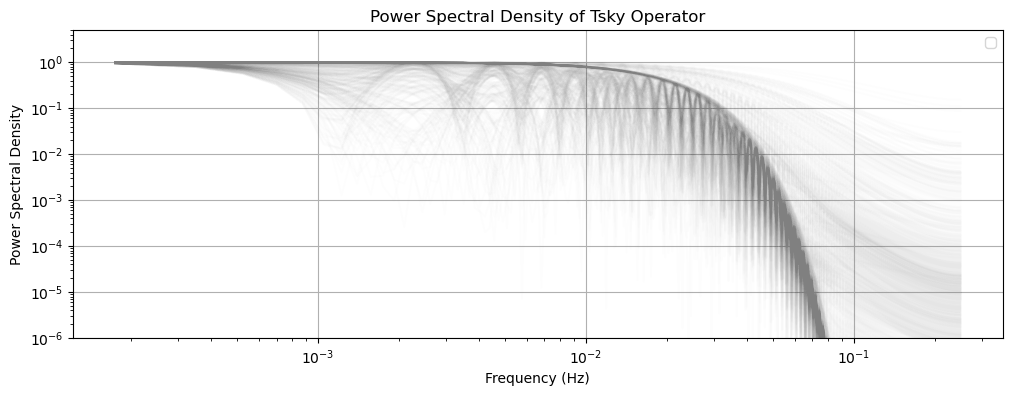

In [4]:
aux_oper_dft = np.fft.fft(aux_oper, axis=0)
fft_freq = np.fft.fftfreq(aux_oper.shape[0], d=2)
aux_oper_PSDs = np.abs(aux_oper_dft)**2 / aux_oper.shape[0] * 2
# Normalize the PSDs
aux_oper_PSDs /= np.max(aux_oper_PSDs, axis=0)
mask = fft_freq > 0
plt.figure(figsize=(12, 4))
for i in range(aux_oper_PSDs.shape[1]):
    plt.loglog(fft_freq[mask], aux_oper_PSDs[mask, i], alpha=0.01, color='gray')
# plt.loglog(fft_freq[mask], np.mean(aux_oper_PSDs[mask, :], axis=1), label='Tsky Operator PSD')
plt.ylim([1e-6, 5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Tsky Operator')

plt.legend()
plt.grid()
plt.show()  

## Prepare the experimental setup

In [5]:
nside = 64

In [6]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
_, eq_coords_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397", return_eq_coords=True)
t_list, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.

_, eq_coords_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397", return_eq_coords=True)
t_list, theta_c_rising, phi_c_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397")
bool_map_rising, integrated_beam_rising = stacked_beam_map(theta_c_rising, 
                                                            phi_c_rising, 
                                                            FWHM=1.1, 
                                                            NSIDE=nside, 
                                                            threshold = 0.0111)

In [7]:
bool_map_single_beam, single_beam = stacked_beam_map(np.array([1.5]), 
                                       np.array([1.5]), 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.
np.sum(bool_map_single_beam)


np.int64(8)

In [8]:
full_bool_map = multi_tod_sim.full_bool_map
pixel_indices = multi_tod_sim.pixel_indices
bool_map_setting, bool_map_rising = multi_tod_sim.bool_map_setting, multi_tod_sim.bool_map_rising
integrated_beam = multi_tod_sim.integrated_beam 

Tsky_operator_setting = multi_tod_sim.Tsky_operator_setting
Tsky_operator_rising = multi_tod_sim.Tsky_operator_rising


In [9]:
def sky_vector(pix_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside) * (freq / 408)**(-2.3)
    skymap = skymap + ptsrc_map
    return skymap[pix_indices]

In [10]:
pixel_indices_setting = np.where(bool_map_setting)[0]
pixel_indices_rising = np.where(bool_map_rising)[0]
sky_params_setting = sky_vector(pixel_indices_setting, 750, Nside=nside, sky_model=None)
sky_params_rising = sky_vector(pixel_indices_rising, 750, Nside=nside, sky_model=None)

calibration_indices = tod_sim.calibration_1_indice
pixel_indices_setting_1 = pixel_indices_setting[calibration_indices]
print(pixel_indices_setting_1)


calibration_5_indices = tod_sim.calibration_5_indices
pixel_indices_setting_5 = pixel_indices_setting[calibration_5_indices]


[21996]


In [11]:
sky_params = sky_vector(pixel_indices, 750, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

calibration_db_indices = multi_tod_sim.calibration_1_index
pixel_indices_db_1 = pixel_indices[calibration_db_indices]

calibration_db_5indices = multi_tod_sim.calibration_5_indices
pixel_indices_db_5 = pixel_indices[calibration_db_5indices]

Number of pixels:  473


In [12]:
# Obtain (RA, DEC) coordinates for the pixels:
# For pixel_indices_setting_1:
theta_s_1, phi_s_1 = hp.pix2ang(nside, pixel_indices_setting_1)
ra_s_1 = np.degrees(phi_s_1)
dec_s_1 = 90.0 - np.degrees(theta_s_1) 

theta_s_5, phi_s_5 = hp.pix2ang(nside, pixel_indices_setting_5)
ra_s_5 = np.degrees(phi_s_5)
dec_s_5 = 90.0 - np.degrees(theta_s_5) 

theta_db_1, phi_db_1 = hp.pix2ang(nside, pixel_indices_db_1)
ra_db_1 = np.degrees(phi_db_1)
dec_db_1 = 90.0 - np.degrees(theta_db_1)

theta_db_5, phi_db_5 = hp.pix2ang(nside, pixel_indices_db_5)
ra_db_5 = np.degrees(phi_db_5)
dec_db_5 = 90.0 - np.degrees(theta_db_5)

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/746378188.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_1, dec_s_1,
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/746378188.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_db_5, dec_db_5,


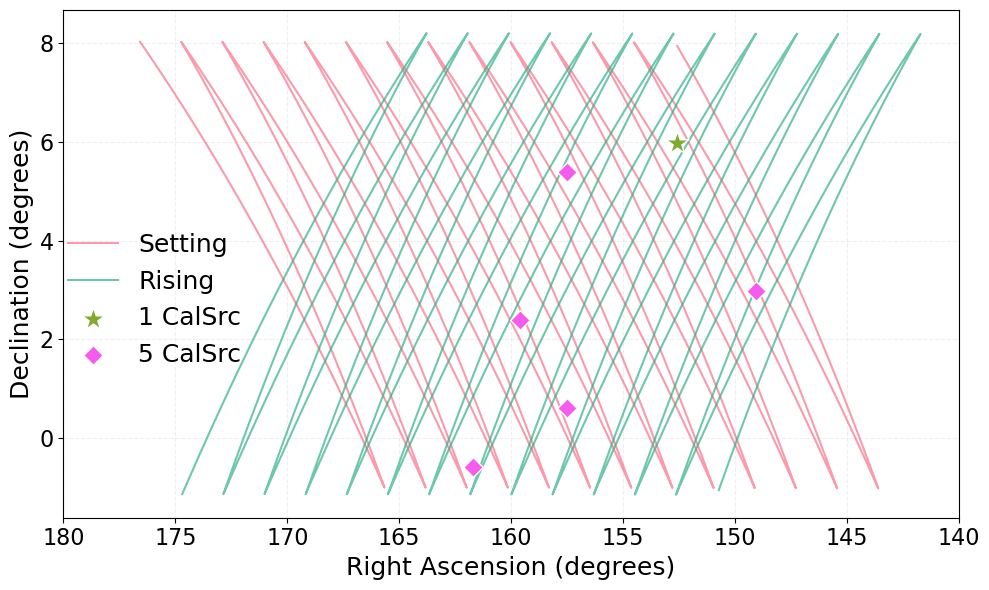

In [13]:
import seaborn as sns


# ---- Plot results ----
plt.figure(figsize=(10, 6))

# Use seaborn color palette
colors = sns.color_palette('husl', 7)

# Plot trajectories with transparency
plt.plot(eq_coords_setting.ra, eq_coords_setting.dec, 
         color=colors[0], 
         alpha=0.7,
         linewidth=1.5,
         label='Setting')
plt.plot(eq_coords_rising.ra, eq_coords_rising.dec, 
         color=colors[3],
         alpha=0.7,
         linewidth=1.5,
         label='Rising')

# Scatter plot with consistent styling

marker_params = {
    'edgecolors': 'w',
    'linewidths': 1,
    'zorder': 3
}

plt.scatter(ra_s_1, dec_s_1, 
            marker='*',
            c=colors[2],
            s=300,
            **marker_params,
            label='1 CalSrc')
# plt.scatter(ra_s_5, dec_s_5,
#             marker='s',
#             c=colors[4],
#             s=100,
#             **marker_params,
#             label='5 CalSrc')
plt.scatter(ra_db_5, dec_db_5,
            marker='D',
            c=colors[6],
            s=100,
            **marker_params,
            label='5 CalSrc')

fts=18

# Styling enhancements
plt.xlabel("Right Ascension (degrees)", fontsize=fts)
plt.ylabel("Declination (degrees)", fontsize=fts)
# plt.title("Celestial Coordinates Observation Pattern", fontsize=14, pad=20)
plt.grid(True, alpha=0.2, linestyle='--')
#plt.gca().set_facecolor('#f7f7f7')
plt.xlim(140,180)
plt.gca().invert_xaxis() 

# Legend with better placement
plt.legend(bbox_to_anchor=(0.21, 0.58),
           borderaxespad=0,
           frameon=False,
           # title=' '
           fontsize=fts
           )

# Adjusting the ticks labels size
plt.tick_params(axis='both', which='major', labelsize=fts-2)

plt.tight_layout()
plt.savefig("figures/observation_pattern_2.pdf", bbox_inches='tight',
            pad_inches=0.1)
plt.show()

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/1397100613.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_1, dec_s_1,
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/1397100613.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_5, dec_s_5,


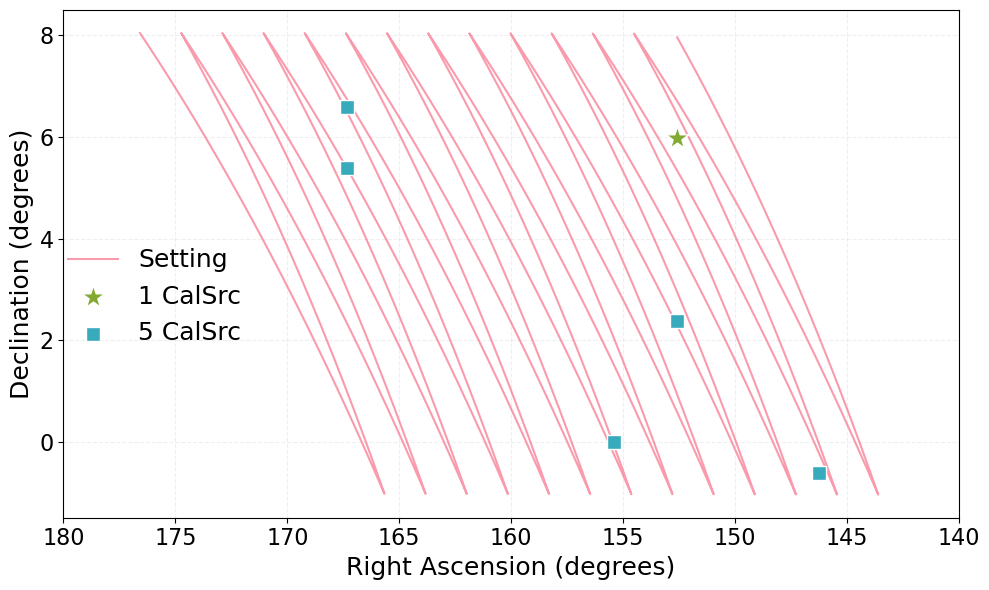

In [14]:
# ---- Plot results ----
plt.figure(figsize=(10, 6))

# Use seaborn color palette
colors = sns.color_palette('husl', 7)

# Plot trajectories with transparency
plt.plot(eq_coords_setting.ra, eq_coords_setting.dec, 
         color=colors[0], 
         alpha=0.7,
         linewidth=1.5,
         label='Setting')

# Scatter plot with consistent styling

marker_params = {
    'edgecolors': 'w',
    'linewidths': 1,
    'zorder': 3
}

plt.scatter(ra_s_1, dec_s_1, 
            marker='*',
            c=colors[2],
            s=300,
            **marker_params,
            label='1 CalSrc')
plt.scatter(ra_s_5, dec_s_5,
            marker='s',
            c=colors[4],
            s=100,
            **marker_params,
            label='5 CalSrc')

# Styling enhancements
plt.xlabel("Right Ascension (degrees)", fontsize=fts)
plt.ylabel("Declination (degrees)", fontsize=fts)
# plt.title("Celestial Coordinates Observation Pattern", fontsize=14, pad=20)
plt.grid(True, alpha=0.2, linestyle='--')
# plt.gca().set_facecolor('#f7f7f7')
plt.xlim(140, 180)
plt.gca().invert_xaxis() 

# Legend with better placement
plt.legend(bbox_to_anchor=(0.21, 0.55),
           borderaxespad=0,
           frameon=False,
           # title=' '
           fontsize=fts
           )

# Adjusting the ticks labels size
plt.tick_params(axis='both', which='major', labelsize=fts-2)

plt.tight_layout()
plt.savefig("figures/observation_pattern_1.pdf", bbox_inches='tight',
            pad_inches=0.1)
plt.show()

# B. Visualise the samples

In [15]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ntime = len(t_list)
ndiode_proj = generate_vector(ntime)

nd_rec_operator = np.zeros((ntime, 5))
# nd_rec_operator[:, 0] = ndiode_proj    # The noise diode part
nd_rec_operator[:, 1:] = Leg_poly_proj(4, t_list) # The Legendre polynomial (receiver temperature and all) part

Leg_4_proj = Leg_poly_proj(4, t_list)

def TOD_samples(ind, gain_samples, Tsky_samples, rec_samples, Tsky_proj):
    gains_instance = Leg_4_proj@gain_samples[ind]
    return gains_instance * (Tsky_proj@Tsky_samples[ind] + Leg_4_proj@rec_samples[ind])


In [16]:
alpha = 2.0
logf0=-4.874571109426952
gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])
gain_params_rising = np.array([6.84507868, 0.14156859, 0.7441104, 0.77863955])
rec_params = np.array([15.0, 12.6, 0.5, 0.5, 0.5])

In [17]:
true_others_1 = np.hstack((gain_params_setting, rec_params, [logf0, alpha]))
true_others_2 = np.hstack((gain_params_setting, gain_params_rising, rec_params, rec_params, [logf0, alpha], [logf0, alpha]))

In [18]:
def intersect_with_indices(arr1, arr2):
    """
    Returns the intersection of arr1 and arr2, along with the indices in arr1 and arr2.
    """
    import numpy as np
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    intersection, idx_arr1, idx_arr2 = np.intersect1d(arr1, arr2, return_indices=True)
    return intersection, idx_arr1, idx_arr2

def get_subset_indices(pixel_indices, pixel_indices_setting):
    """
    Returns the indices in pixel_indices corresponding to each value in pixel_indices_setting.
    Assumes all elements of pixel_indices_setting are present in pixel_indices.
    """
    import numpy as np
    pixel_indices = np.asarray(pixel_indices)
    pixel_indices_setting = np.asarray(pixel_indices_setting)
    # Create a mapping from value to index for fast lookup
    value_to_index = {val: idx for idx, val in enumerate(pixel_indices)}
    # Get the indices for each value in pixel_indices_setting
    indices = [value_to_index[val] for val in pixel_indices_setting]
    return np.array(indices)

common_pix, _, _ = intersect_with_indices(pixel_indices_setting, pixel_indices_rising)
print(len(common_pix))

inds_common_pix_in_setting = get_subset_indices(pixel_indices_setting, common_pix)
inds_common_pix_in_db = get_subset_indices(pixel_indices, common_pix)

292


In [19]:
def calculate_coverage_maps(samples, true_sky):
    """Calculate coverage violation maps"""
    
    # Calculate percentiles
    p16 = np.percentile(samples, 16, axis=0)
    p84 = np.percentile(samples, 84, axis=0)
    ci_68_width = p84 - p16
    p2p5 = np.percentile(samples, 2.5, axis=0)
    p97p5 = np.percentile(samples, 97.5, axis=0)
    median = np.median(samples, axis=0)
    residual = median - true_sky
    
    # Coverage checks
    within_68 = (true_sky >= p16) & (true_sky <= p84)
    within_95 = (true_sky >= p2p5) & (true_sky <= p97p5)
    
    # Create violation maps with different levels
    # 0 = within 68%, 1 = outside 68% but within 90%, 2 = outside 90% but within 95%, 3 = outside 95%
    coverage_map = np.zeros_like(true_sky)
    coverage_map[~within_68] = 1  # Outside 68%
    coverage_map[~within_95] = 2  # Outside 95%

    return median, residual, ci_68_width, coverage_map

# Read the saved samples

GS1_Tsys_samples = np.load('outputs/GS1/Tsys_samples.npy')
GS1_gain_samples = np.load('outputs/GS1/gain_samples.npy')
GS1_noise_samples = np.load('outputs/GS1/noise_samples.npy')
GS1_Tsky = GS1_Tsys_samples[:, :-5]
GS1_Tsky_mean = np.mean(GS1_Tsky, axis=0)
GS1_Tsky_std = np.std(GS1_Tsky, axis=0)
GS1_Tsky_residual = GS1_Tsky_mean - sky_params_setting
GS1_Tsky_residual_common = GS1_Tsky_residual[inds_common_pix_in_setting]
GS1_others = np.hstack((GS1_gain_samples[0], GS1_Tsys_samples[:, -5:], GS1_noise_samples[0]))

GS1_Tsky_median, GS1_Tsky_median_residual, GS1_Tsky_ci_68, GS1_Tsky_coverage = calculate_coverage_maps(GS1_Tsky, sky_params_setting)
GS1_Tsky_median_residual_common = GS1_Tsky_median_residual[inds_common_pix_in_setting]



GS5_Tsys_samples = np.load('outputs/GS5/Tsys_samples.npy')
GS5_gain_samples = np.load('outputs/GS5/gain_samples.npy')
GS5_noise_samples = np.load('outputs/GS5/noise_samples.npy')
GS5_Tsky = GS5_Tsys_samples[:, :-5]
GS5_Tsky_mean = np.mean(GS5_Tsky, axis=0)
GS5_Tsky_std = np.std(GS5_Tsky, axis=0)
GS5_Tsky_residual = GS5_Tsky_mean - sky_params_setting
GS5_Tsky_residual_common = GS5_Tsky_residual[inds_common_pix_in_setting]
GS5_others = np.hstack((GS5_gain_samples[0], GS5_Tsys_samples[:, -5:], GS5_noise_samples[0]))

GS5_Tsky_median, GS5_Tsky_median_residual, GS5_Tsky_ci_68, GS5_Tsky_coverage = calculate_coverage_maps(GS5_Tsky, sky_params_setting)
GS5_Tsky_median_residual_common = GS5_Tsky_median_residual[inds_common_pix_in_setting]

GSF5_Tsys_samples = np.load('outputs/GSF5/Tsys_samples.npy')
GSF5_gain_samples = np.load('outputs/GSF5/gain_samples.npy')
GSF5_noise_samples = np.load('outputs/GSF5/noise_samples.npy')
GSF5_Tsky = GSF5_Tsys_samples[:, :-5]
GSF5_Tsky_mean = np.mean(GSF5_Tsky, axis=0)
GSF5_Tsky_std = np.std(GSF5_Tsky, axis=0)
GSF5_Tsky_residual = GSF5_Tsky_mean - sky_params_setting
GSF5_Tsky_residual_common = GSF5_Tsky_residual[inds_common_pix_in_setting]
GSF5_others = np.hstack((GSF5_gain_samples[0], GSF5_Tsys_samples[:, -5:], GSF5_noise_samples[0]))

GSF5_Tsky_median, GSF5_Tsky_median_residual, GSF5_Tsky_ci_68, GSF5_Tsky_coverage = calculate_coverage_maps(GSF5_Tsky, sky_params_setting)
GSF5_Tsky_median_residual_common = GSF5_Tsky_median_residual[inds_common_pix_in_setting]

GS1_db_Tsys_samples = np.load('outputs/GS1_db/Tsys_samples.npy')
GS1_db_gain_samples = np.load('outputs/GS1_db/gain_samples.npy')
GS1_db_noise_samples = np.load('outputs/GS1_db/noise_samples.npy')
GS1_db_Tsky = GS1_db_Tsys_samples[:, :-10]
GS1_db_Tsky_mean = np.mean(GS1_db_Tsky, axis=0)
GS1_db_Tsky_std = np.std(GS1_db_Tsky, axis=0)
GS1_db_Tsky_residual = GS1_db_Tsky_mean - sky_params
GS1_db_Tsky_residual_common = GS1_db_Tsky_residual[inds_common_pix_in_db]
GS1_db_others = np.hstack((GS1_db_gain_samples[0], GS1_db_gain_samples[1], GS1_db_Tsys_samples[:, -10:], 
                           GS1_db_noise_samples[0], GS1_db_noise_samples[1]))

GS1_db_Tsky_median, GS1_db_Tsky_median_residual, GS1_db_Tsky_ci_68, GS1_db_Tsky_coverage = calculate_coverage_maps(GS1_db_Tsky, sky_params)
GS1_db_Tsky_median_residual_common = GS1_db_Tsky_median_residual[inds_common_pix_in_db]

GS5_db_Tsys_samples = np.load('outputs/GS5_db/Tsys_samples.npy')
GS5_db_gain_samples = np.load('outputs/GS5_db/gain_samples.npy')
GS5_db_noise_samples = np.load('outputs/GS5_db/noise_samples.npy')
GS5_db_Tsky = GS5_db_Tsys_samples[:, :-10]
GS5_db_Tsky_mean = np.mean(GS5_db_Tsky, axis=0)
GS5_db_Tsky_std = np.std(GS5_db_Tsky, axis=0)
GS5_db_Tsky_residual = GS5_db_Tsky_mean - sky_params
GS5_db_Tsky_residual_common = GS5_db_Tsky_residual[inds_common_pix_in_db]
GS5_db_others = np.hstack((GS5_db_gain_samples[0], GS5_db_gain_samples[1], GS5_db_Tsys_samples[:, -10:], 
                           GS5_db_noise_samples[0], GS5_db_noise_samples[1]))
GS5_db_Tsky_median, GS5_db_Tsky_median_residual, GS5_db_Tsky_ci_68, GS5_db_Tsky_coverage = calculate_coverage_maps(GS5_db_Tsky, sky_params)
GS5_db_Tsky_median_residual_common = GS5_db_Tsky_median_residual[inds_common_pix_in_db]


GSF5_db_Tsys_samples = np.load('outputs/GSF5_db/Tsys_samples.npy')
GSF5_db_gain_samples = np.load('outputs/GSF5_db/gain_samples.npy')
GSF5_db_noise_samples = np.load('outputs/GSF5_db/noise_samples.npy')
GSF5_db_Tsky = GSF5_db_Tsys_samples[:, :-10]
GSF5_db_Tsky_mean = np.mean(GSF5_db_Tsky, axis=0)
GSF5_db_Tsky_std = np.std(GSF5_db_Tsky, axis=0)
GSF5_db_Tsky_residual = GSF5_db_Tsky_mean - sky_params
GSF5_db_Tsky_residual_common = GSF5_db_Tsky_residual[inds_common_pix_in_db]
GSF5_db_others = np.hstack((GSF5_db_gain_samples[0], GSF5_db_gain_samples[1], GSF5_db_Tsys_samples[:, -10:], 
                           GSF5_db_noise_samples[0], GSF5_db_noise_samples[1]))

GSF5_db_Tsky_median, GSF5_db_Tsky_median_residual, GSF5_db_Tsky_ci_68, GSF5_db_Tsky_coverage = calculate_coverage_maps(GSF5_db_Tsky, sky_params)
GSF5_db_Tsky_median_residual_common = GSF5_db_Tsky_median_residual[inds_common_pix_in_db]


In [20]:
tod_obs_setting = (Leg_4_proj@gain_params_setting)*(Tsky_operator_setting@sky_params + Leg_4_proj@rec_params[1:]) # noise free

gain_samples = GSF5_db_gain_samples[0]
Tsky_samples = GSF5_db_Tsky
rec_samples = GSF5_db_Tsys_samples[:, -9:-5]
Tsky_proj = Tsky_operator_setting
nd_rec_operator = multi_tod_sim.nd_rec_operator

# Generate reconstructed TODs from samples
tod_preds = np.array([TOD_samples(ind, gain_samples, Tsky_samples, rec_samples, Tsky_proj)
                    for ind in range(1000)])  # shape: (N_samples, N_time)

# Compute statistics over samples
mean_tod = np.mean(tod_preds, axis=0)
lower_1sigma = np.percentile(tod_preds, 16, axis=0)
upper_1sigma = np.percentile(tod_preds, 84, axis=0)

lower_2sigma = np.percentile(tod_preds, 2.5, axis=0)
upper_2sigma = np.percentile(tod_preds, 97.5, axis=0)

In [21]:
def TOD_samples_with_nd(ind, gain_samples, Tsky_samples, nd_rec_samples, Tsky_proj, nd_rec_operator):
    gains_instance = Leg_4_proj@gain_samples[ind]
    return gains_instance * (Tsky_proj@Tsky_samples[ind] + nd_rec_operator@nd_rec_samples[ind])

tod_preds_with_nd = np.array([TOD_samples_with_nd(ind, gain_samples, Tsky_samples, GSF5_db_Tsys_samples[:, -10:-5], Tsky_proj, nd_rec_operator)
                             for ind in range(1000)])  # shape: (N_samples, N_time)
# mean_tod_with_nd = np.mean(tod_preds_with_nd, axis=0)
tod_obs_setting_with_nd = (Leg_4_proj@gain_params_setting)*(Tsky_operator_setting@sky_params + nd_rec_operator@multi_tod_sim.nd_rec_params)
# Calculate residuals
frac_residual_allsamples_with_nd = (tod_preds_with_nd - tod_obs_setting_with_nd[np.newaxis, :]) / tod_obs_setting_with_nd[np.newaxis, :]
# Calculate mean fractional residual
frac_residual_mean_with_nd = np.mean(frac_residual_allsamples_with_nd, axis=0)

In [22]:
multi_tod_sim.t_list

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 5.714e+03, 5.716e+03,
       5.718e+03], shape=(2860,))

In [23]:
try:
    import pickle
    import os

    emulator_path = '../hydra_tod/flicker_corr_emulator.pkl'

    # Import the class definition before unpickling
    from flicker_model import FlickerCorrEmulator

    # Load the emulator
    with open(emulator_path, 'rb') as f:
        flicker_cov = pickle.load(f)
    use_emulator = True
    print("Using the emulator for flicker noise correlation function.")
except (FileNotFoundError, ImportError, AttributeError) as e:
    print(f"Emulator for flicker noise correlation function not found or failed to load: {e}")
    print("Using flicker_cov_vec instead.")
    from flicker_model import flicker_cov_vec as flicker_cov
    use_emulator = False


Using the emulator for flicker noise correlation function.


In [24]:
def PSD_with_DFT(tod, dt=2.0):
    """
    Calculate the Power Spectral Density (PSD) of a given time-ordered data (TOD) using DFT.
    
    Parameters:
        tod (np.ndarray): The time-ordered data.
        dt (float): The time interval between samples.
        
    Returns:
        tuple: Frequencies and corresponding PSD values.
    """
    n = len(tod)
    dft = np.fft.fft(tod)
    psd = np.abs(dft)**2 / n * dt  # Normalize the PSD
    freqs = np.fft.fftfreq(n, d=dt)

    mask = freqs > 0  # Only keep positive frequencies
    freqs = freqs[mask]
    psd = psd[mask]
    
    return freqs, psd

In [25]:
N_samples = 1000

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/79123555.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 1])


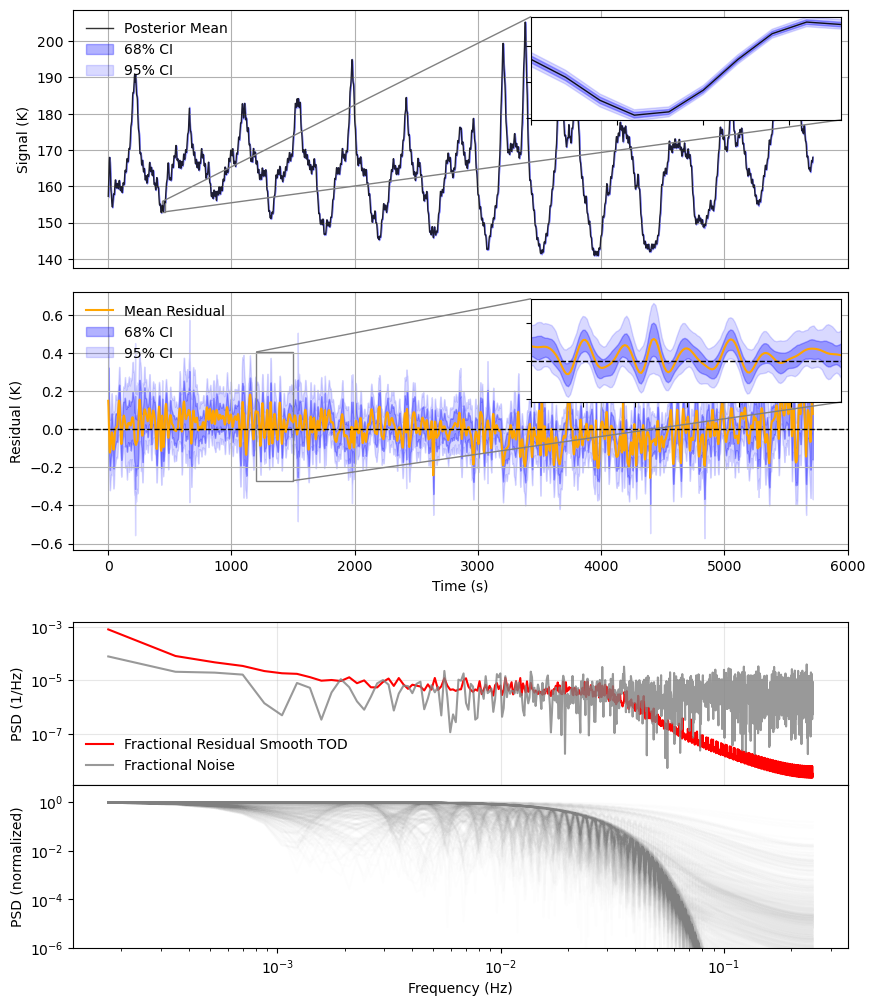

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.gridspec import GridSpec
import scipy.signal as signal

# Compute residuals and their confidence intervals (!!! Noise-free !!!)
residual_mean = mean_tod - tod_obs_setting
frac_res_mean = residual_mean / tod_obs_setting  # fractional residuals
residual_lower_1sigma = lower_1sigma - tod_obs_setting
residual_upper_1sigma = upper_1sigma - tod_obs_setting
residual_lower_2sigma = lower_2sigma - tod_obs_setting
residual_upper_2sigma = upper_2sigma - tod_obs_setting

# Compute power spectrum of residuals - mean PSD of (tod_preds - truth)
dt = np.mean(np.diff(t_list))  # sampling interval
# Calculate PSD for each sample's residual
residuals_all_samples = (tod_preds - tod_obs_setting[np.newaxis, :] )/ tod_obs_setting[np.newaxis, :]  # shape: (N_samples, N_time)
psd_list = []
for i in range(residuals_all_samples.shape[0]):
    #freqs_temp, psd_temp = signal.welch(residuals_all_samples[i], fs=1/dt, nperseg=len(residual_mean)//4)
    freqs_temp, psd_temp = PSD_with_DFT(residuals_all_samples[i])
    psd_list.append(psd_temp)

# Calculate mean PSD across all samples
psd_list = np.array(psd_list)
psd_residual = np.mean(psd_list, axis=0)
freqs = freqs_temp  # All samples have the same frequency array

true_noise = multi_tod_sim.noise_setting
# Calculate the true noise PSD
freqs_noise, psd_noise = PSD_with_DFT(true_noise)
# signal.welch(true_noise, fs=1/dt, nperseg=len(residual_mean)//4)




fig = plt.figure(figsize=(10, 12))

# Use GridSpec for fine control over subplot spacing
gs = GridSpec(10, 1, figure=fig, hspace=0.4)  # Overall spacing

# Create compact subplots with better proportions - first two panels share x-axis
# Top panel (main signal)
ax = fig.add_subplot(gs[0:3, 0])  # rows 0-2
ax.plot(t_list, mean_tod, label='Posterior Mean', color='black', lw=1, alpha=0.8)
ax.fill_between(t_list, lower_1sigma, upper_1sigma, color='blue', alpha=0.3, label='68% CI')
ax.fill_between(t_list, lower_2sigma, upper_2sigma, color='blue', alpha=0.15, label='95% CI')
ax.set_ylabel('Signal (K)')
ax.legend(loc='upper left', frameon=False)
ax.grid(True)
# Completely turn off x-axis for top panel - no labels, no ticks, no space
ax.tick_params(labelbottom=False, bottom=False)
ax.set_xticklabels([])
plt.setp(ax.get_xticklabels(), visible=False)

# Inset for zoomed region
segment_start = 220
segment_end = 230
main_y = tod_obs_setting[segment_start:segment_end]
mean_y = mean_tod[segment_start:segment_end]
y_min = min(np.min(main_y), np.min(mean_y))
y_max = max(np.max(main_y), np.max(mean_y))
margin = 0.05 * (y_max - y_min)
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
axins.plot(t_list, mean_tod, color='black', lw=1, alpha=0.9)
axins.fill_between(t_list, lower_1sigma, upper_1sigma, color='blue', alpha=0.3)
axins.fill_between(t_list, lower_2sigma, upper_2sigma, color='blue', alpha=0.15)
axins.set_xlim(t_list[segment_start], t_list[segment_end-1])
axins.set_ylim(y_min - margin, y_max + margin)
axins.set_xticklabels([])
axins.set_yticklabels([])
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Middle panel: residuals (tight against top panel)
ax2 = fig.add_subplot(gs[3:6, 0])  # rows 2-3  
ax2.plot(t_list, residual_mean, color='orange', lw=1.5, label='Mean Residual')
ax2.fill_between(t_list, residual_lower_1sigma, residual_upper_1sigma, color='blue', alpha=0.3, label='68% CI')
ax2.fill_between(t_list, residual_lower_2sigma, residual_upper_2sigma, color='blue', alpha=0.15, label='95% CI')
ax2.axhline(0, color='black', lw=1, linestyle='--')
ax2.set_ylabel('Residual (K)')
ax2.set_xlabel('Time (s)')
ax2.legend(loc='upper left', frameon=False)
ax2.grid(True)
# Set same x-axis limits as top panel
ax2.set_xlim(ax.get_xlim())

# Inset for zoomed residual region
residual_segment_start = 600
residual_segment_end = 750
residual_y = residual_mean[residual_segment_start:residual_segment_end]
residual_1s_lower = residual_lower_1sigma[residual_segment_start:residual_segment_end]
residual_1s_upper = residual_upper_1sigma[residual_segment_start:residual_segment_end]
residual_2s_lower = residual_lower_2sigma[residual_segment_start:residual_segment_end]
residual_2s_upper = residual_upper_2sigma[residual_segment_start:residual_segment_end]
residual_y_min = min(np.min(residual_2s_lower), np.min(residual_y))
residual_y_max = max(np.max(residual_2s_upper), np.max(residual_y))
residual_margin = 0.05 * (residual_y_max - residual_y_min)
axins2 = inset_axes(ax2, width="40%", height="40%", loc='upper right')
axins2.plot(t_list, residual_mean, color='orange', lw=1.5)
axins2.fill_between(t_list, residual_lower_1sigma, residual_upper_1sigma, color='blue', alpha=0.3)
axins2.fill_between(t_list, residual_lower_2sigma, residual_upper_2sigma, color='blue', alpha=0.15)
axins2.axhline(0, color='black', lw=1, linestyle='--')
axins2.set_xlim(t_list[residual_segment_start], t_list[residual_segment_end-1])
axins2.set_ylim(residual_y_min - residual_margin, residual_y_max + residual_margin)
axins2.set_xticklabels([])
axins2.set_yticklabels([])
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5")

# Bottom panel: power spectrum (with normal spacing)
ax3 = fig.add_subplot(gs[6:8, 0])  
ax3.loglog(freqs, psd_residual, color='red', lw=1.5, label='Fractional Residual Smooth TOD')
ax3.loglog(freqs_noise, psd_noise, color='gray', lw=1.5, alpha=0.8, label='Fractional Noise')


ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel(r'PSD (1/Hz)')
ax3.legend(loc='lower left', frameon=False)
ax3.grid(True, alpha=0.3)
# Remove x-axis labels and ticks from top panel
ax3.tick_params(labelbottom=False, bottom=False)
ax3.set_xlabel('')  # Remove x-label from top panel

ax4 = fig.add_subplot(gs[8:, 0])  
aux_oper_dft = np.fft.fft(aux_oper, axis=0)
fft_freq = np.fft.fftfreq(aux_oper.shape[0], d=2)
aux_oper_PSDs = np.abs(aux_oper_dft)**2 / aux_oper.shape[0] * 2
# Normalize the PSDs
aux_oper_PSDs /= np.max(aux_oper_PSDs, axis=0)
mask = fft_freq > 0
for i in range(aux_oper_PSDs.shape[1]):
    ax4.loglog(fft_freq[mask], aux_oper_PSDs[mask, i], alpha=0.01, color='gray')
# ax4.loglog(fft_freq[mask], np.mean(aux_oper_PSDs[mask, :], axis=1), label='Tsky Operator PSD')
ax4.set_ylim([1e-6, 5])
ax4.set_xlim([freqs[0], freqs[-1]])
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('PSD (normalized)')

# Ensure both panels have the same x-axis limits
ax4.set_xlim(ax3.get_xlim())

# ax4.legend()

# Manually adjust spacing: minimal between first two, normal before power spectrum
pos1 = ax.get_position()
pos2 = ax2.get_position()
pos3 = ax3.get_position()
pos4 = ax4.get_position()

# Move middle panel closer to top panel
pos2_new = [pos2.x0, pos1.y0 - pos2.height - 0.02, pos2.width, pos2.height]
ax2.set_position(pos2_new)

# Keep normal spacing for power spectrum panel
pos3_new = [pos3.x0, pos2_new[1] - pos3.height - 0.06, pos3.width, pos3.height]
ax3.set_position(pos3_new)
# Keep normal spacing for aux operator panel
pos4_new = [pos4.x0, pos3_new[1] - pos4.height , pos4.width, pos4.height]
ax4.set_position(pos4_new)

plt.tight_layout(rect=[0, 0.02, 1, 1]) 
plt.savefig('figures/TOD_reconstruction_with_residual_2.pdf', bbox_inches='tight')
plt.show()

In [27]:
count_1sigma=0
count_2sigma=0
for i in range(len(residual_mean)):
    if 0 > residual_upper_1sigma[i] or 0 < residual_lower_1sigma[i]:
        count_1sigma += 1
        if 0 > residual_upper_2sigma[i] or 0 < residual_lower_2sigma[i]:
            count_2sigma += 1
print(count_1sigma/len(residual_mean))
print(count_2sigma/len(residual_mean))

0.2923076923076923
0.028321678321678322


In [105]:
def plot_residual_histogram(type_str,
                            residuals, 
                            residuals_common,
                            binwidth=0.05,
                            fts=28,  # Increased from 19 to 27
                            kde=False,
                            save_path=None,
                            figsize=(12, 7),
                            show_mean=False,
                            show_std=True,
                            colors=None,
                            title=None,
                            print_xlabel=False,
                            print_ylabel=False,
                            xlim=None,
                            legend=False):
    """
    Plots two histograms: one of all residuals as the gray background and, on top of it, one of common residuals in red,
    including mean and 16th–84th percentile annotations.

    Parameters:
        residuals (array-like): Array of all residual values (in gray).
        residuals_common (array-like): Array of common residual values (in red).
        binwidth (float): Width of histogram bins
        fts (int): Font size for labels
        kde (bool): Whether to show KDE overlay
        save_path (str): Path to save the figure
        figsize (tuple): Figure size (width, height)
        show_mean (bool): Whether to show mean lines
        show_std (bool): Whether to show standard deviation in text
        colors (dict): Custom color scheme
        title (str): Plot title
        xlim (tuple): x-axis limits
    """
    # Default colors
    if colors is None:
        colors = {
            'all': '#7f8c8d',      # Sophisticated gray
            'common': '#e74c3c',    # Red
            'all_lines': '#2980b9', # Blue
            'common_lines': '#c0392b', # Dark red
            'mean_all': '#34495e',   # Dark gray
            'mean_common': '#a93226' # Dark red
        }
    
    # Set up the plot with better styling
    plt.figure(figsize=figsize)
    sns.set_theme(style='white')  # Changed from 'whitegrid' to 'white' to remove grid
    
    # Calculate common bin edges for consistent comparison
    all_data = np.concatenate([residuals, residuals_common])
    if xlim is None:
        data_range = np.max(all_data) - np.min(all_data)
        margin = 0.1 * data_range
        xlim = (np.min(all_data) - margin, np.max(all_data) + margin)
    
    # Calculate bins
    n_bins = int((xlim[1] - xlim[0]) / binwidth)
    bins = np.linspace(xlim[0], xlim[1], n_bins)

    # Plot histogram of all pixels as background
    ax = plt.gca()
    n_all, bins_all, patches_all = plt.hist(residuals, bins=bins, 
                                            color=colors['all'], 
                                            alpha=0.8, 
                                            density=False,
                                            edgecolor='white', 
                                            linewidth=0.5,
                                            label='All pixels')

    # Plot histogram of common residuals on top
    n_common, bins_common, patches_common = plt.hist(residuals_common, bins=bins,
                                                     color=colors['common'], 
                                                     alpha=0.5, 
                                                     density=False,
                                                     edgecolor='white', 
                                                     linewidth=0.5,
                                                     label='Internal pixels')

    # Add KDE if requested
    if kde:
        from scipy.stats import gaussian_kde
        
        # KDE for all residuals
        kde_all = gaussian_kde(residuals)
        x_kde = np.linspace(xlim[0], xlim[1], 300)
        y_kde_all = kde_all(x_kde)
        plt.plot(x_kde, y_kde_all, color=colors['all'], linestyle='-', 
                linewidth=2, alpha=0.8)
        
        # KDE for common residuals
        kde_common = gaussian_kde(residuals_common)
        y_kde_common = kde_common(x_kde)
        plt.plot(x_kde, y_kde_common, color=colors['common'], linestyle='-', 
                linewidth=2, alpha=0.9)

    # Compute comprehensive statistics
    stats_all = {
        'mean': np.mean(residuals),
        'std': np.std(residuals),
        'median': np.median(residuals),
        'p16': np.percentile(residuals, 16),
        'p84': np.percentile(residuals, 84),
        'rms': np.sqrt(np.mean(residuals**2))
    }
    
    stats_common = {
        'mean': np.mean(residuals_common),
        'std': np.std(residuals_common),
        'median': np.median(residuals_common),
        'p16': np.percentile(residuals_common, 16),
        'p84': np.percentile(residuals_common, 84),
        'rms': np.sqrt(np.mean(residuals_common**2))
    }

    # Print statistics
    print(f"All pixels - Mean: {stats_all['mean']:.4f}, Std: {stats_all['std']:.4f}, RMS: {stats_all['rms']:.4f}")
    print(f"All pixels - 16th-84th percentile: [{stats_all['p16']:.4f}, {stats_all['p84']:.4f}]")
    print(f"Internal pixels - Mean: {stats_common['mean']:.4f}, Std: {stats_common['std']:.4f}, RMS: {stats_common['rms']:.4f}")
    print(f"Internal pixels - 16th-84th percentile: [{stats_common['p16']:.4f}, {stats_common['p84']:.4f}]")

    # Add vertical lines for percentiles
    plt.axvline(stats_all['p16'], color=colors['all_lines'], linestyle=':', 
               lw=3, alpha=0.8, label='All: 16th–84th percentile')  # Increased linewidth
    plt.axvline(stats_all['p84'], color=colors['all_lines'], linestyle=':', lw=3, alpha=0.8)
    
    plt.axvline(stats_common['p16'], color=colors['common_lines'], linestyle='--', 
               lw=3, alpha=0.9, label='Internal: 16th–84th percentile')  # Increased linewidth
    plt.axvline(stats_common['p84'], color=colors['common_lines'], linestyle='--', lw=3, alpha=0.9)
    
    # Add mean lines if requested
    if show_mean:
        plt.axvline(stats_all['mean'], color=colors['mean_all'], linestyle='-', 
                   lw=3, alpha=0.7, label='All: Mean')  # Increased linewidth
        plt.axvline(stats_common['mean'], color=colors['mean_common'], linestyle='-', 
                   lw=3, alpha=0.8, label='Internal: Mean')  # Increased linewidth

    # Set axis limits
    plt.xlim(xlim)
    
    # Enhanced annotations with larger font sizes
    if print_xlabel:
        plt.xlabel(r'$T_{\mathrm{residual}} = \langle T^{\mathrm{sample}}_{\mathrm{sky}} \rangle - T_{\mathrm{sky}}^{\mathrm{true}}$ [K]', 
                fontsize=fts)
    if print_ylabel:
        plt.ylabel('Histogram', fontsize=fts)

    if title:
        plt.title(title, fontsize=fts+4, pad=20)  # Increased from +2 to +4
    
    # plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Enhanced text annotation with larger font size
    text_lines = [
        f'$\\mathbf{{{type_str}}}$',
        f'',
        f'All pixels (n={len(residuals)}):',
        f'   16th–84th pct: [{stats_all["p16"]:.3f}, {stats_all["p84"]:.3f}] K',
        f'   Mean ± Std: {stats_all["mean"]:.3f} ± {stats_all["std"]:.3f} K',
        f'',
        f'Internal pixels (n={len(residuals_common)}):',
        f'   16th–84th pct: [{stats_common["p16"]:.3f}, {stats_common["p84"]:.3f}] K',
        f'   Mean ± Std: {stats_common["mean"]:.3f} ± {stats_common["std"]:.3f} K'
    ]
    
    text_str = '\n'.join(text_lines)
    
    plt.text(0.01, 0.97, text_str,
             transform=ax.transAxes, va='top', ha='left',
             bbox=dict(facecolor='white', alpha=0.5, pad=8),  # Reduced opacity and padding, removed frame
             fontsize=fts-4, fontfamily='sans-serif', color='#555555')  # Changed to sans-serif font and gray text color

    # Enhanced legend with larger font size
    handles, labels = ax.get_legend_handles_labels()
    # Remove duplicate labels
    by_label = dict(zip(labels, handles))
    if legend:
        plt.legend(by_label.values(), by_label.keys(), 
                  loc='upper right', fontsize=fts-3,  # Changed from fts-3 to fts-4, but still larger
                  frameon=False, # framealpha=0.9, edgecolor='gray'
                  )

    # Set tick parameters with larger font sizes
    plt.tick_params(axis='both', which='major', labelsize=fts-2)  # Increased tick label size
    plt.tick_params(axis='both', which='minor', labelsize=fts-4)

    plt.tight_layout()

    # Save plot if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Plot saved to: {save_path}")

    plt.show()
    
    # Return statistics for further analysis
    pass

All pixels - Mean: 0.0008, Std: 0.1422, RMS: 0.1422
All pixels - 16th-84th percentile: [-0.0675, 0.0918]
Internal pixels - Mean: 0.0017, Std: 0.1378, RMS: 0.1378
Internal pixels - 16th-84th percentile: [-0.0558, 0.0793]
Plot saved to: figures/GS1_Tsky_residual.pdf


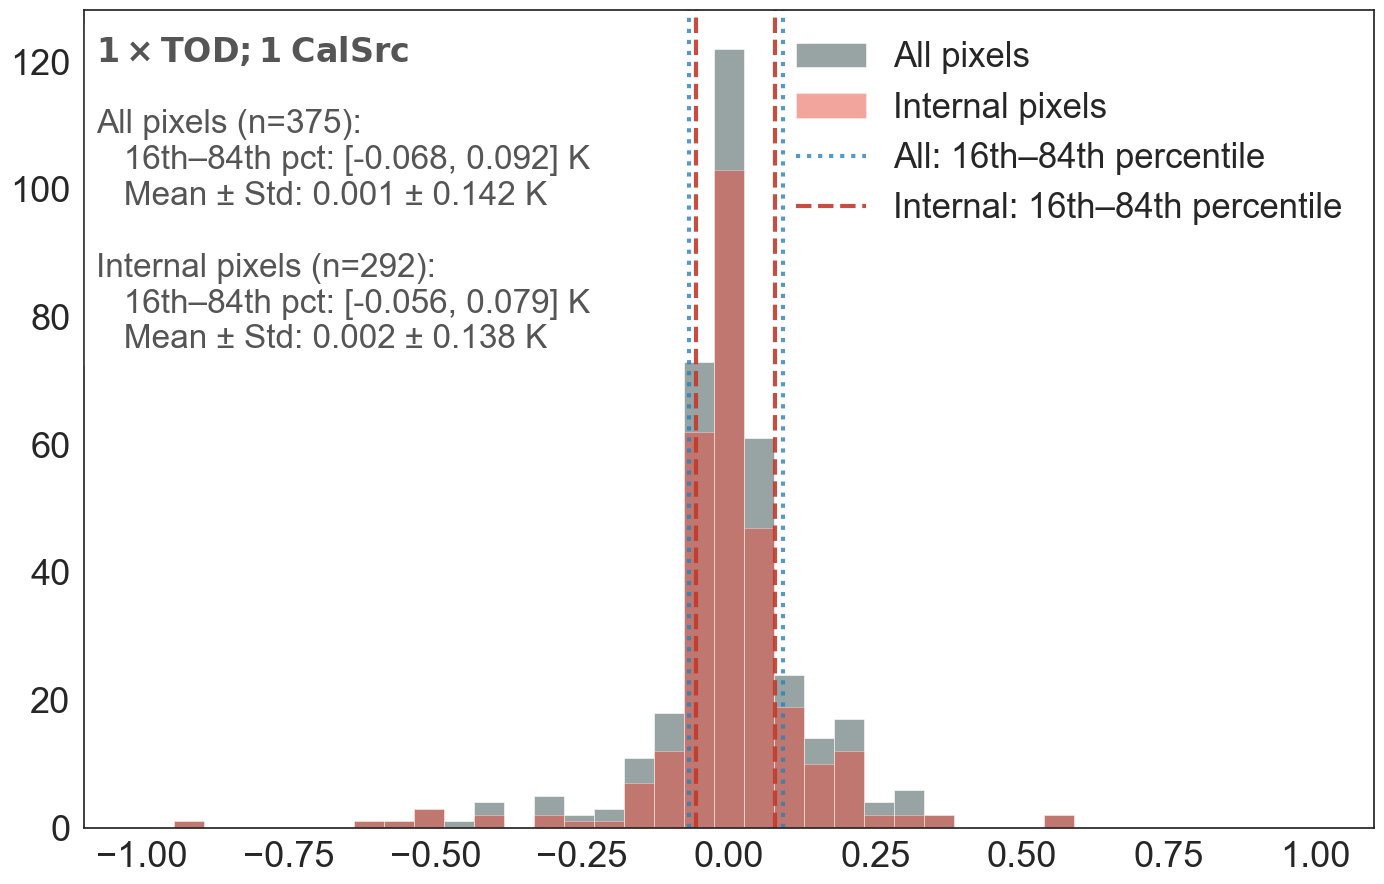

All pixels - Mean: -0.0205, Std: 0.2543, RMS: 0.2551
All pixels - 16th-84th percentile: [-0.0541, 0.0669]
Internal pixels - Mean: -0.0088, Std: 0.1711, RMS: 0.1713
Internal pixels - 16th-84th percentile: [-0.0315, 0.0165]
Plot saved to: figures/GS1_db_Tsky_residual.pdf
Plot saved to: figures/GS1_db_Tsky_residual.pdf


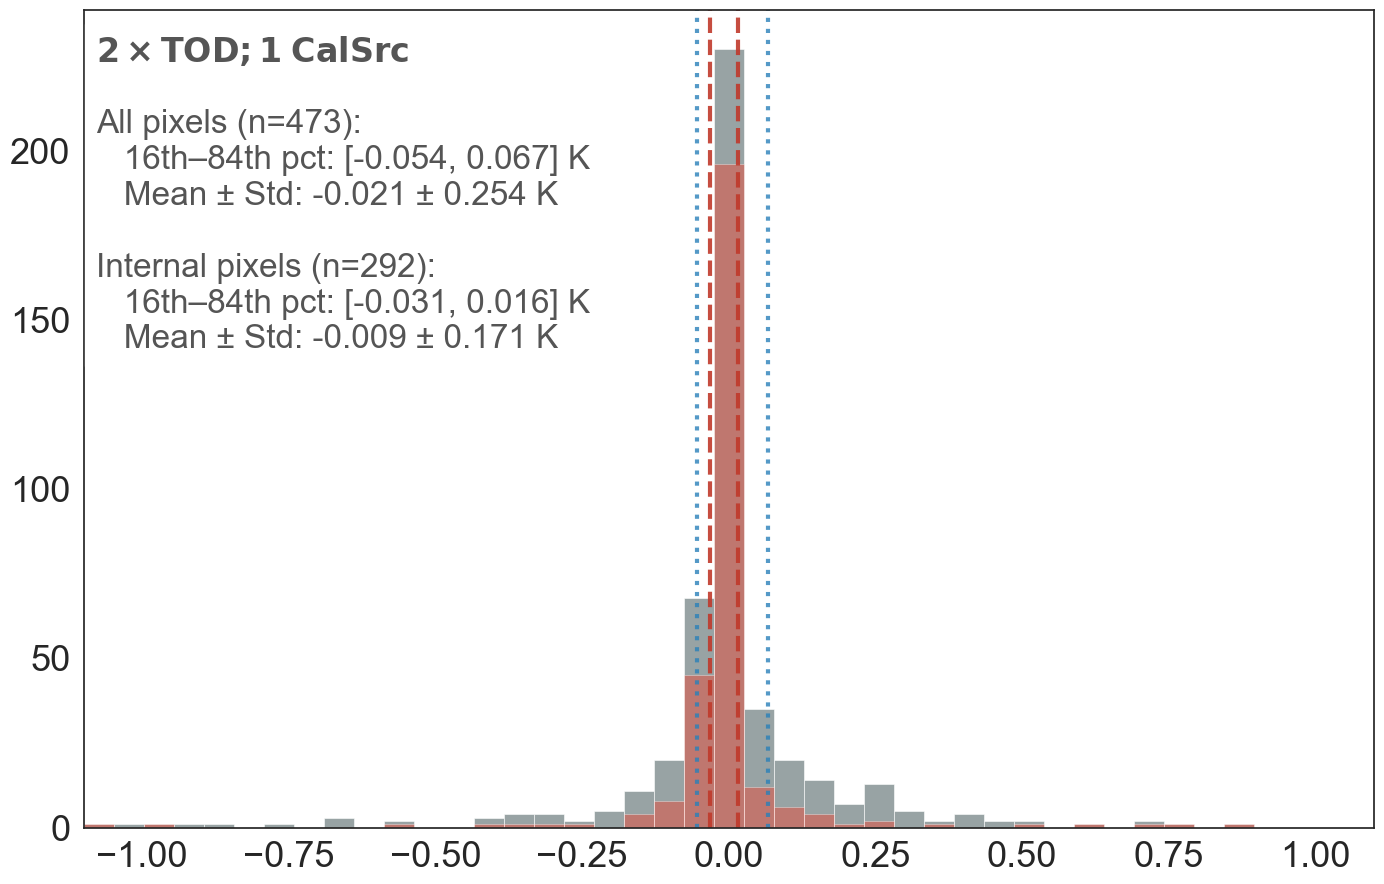

All pixels - Mean: -0.0007, Std: 0.1461, RMS: 0.1461
All pixels - 16th-84th percentile: [-0.0613, 0.0852]
Internal pixels - Mean: -0.0009, Std: 0.1389, RMS: 0.1389
Internal pixels - 16th-84th percentile: [-0.0563, 0.0798]
Plot saved to: figures/GS5_Tsky_residual.pdf
Plot saved to: figures/GS5_Tsky_residual.pdf


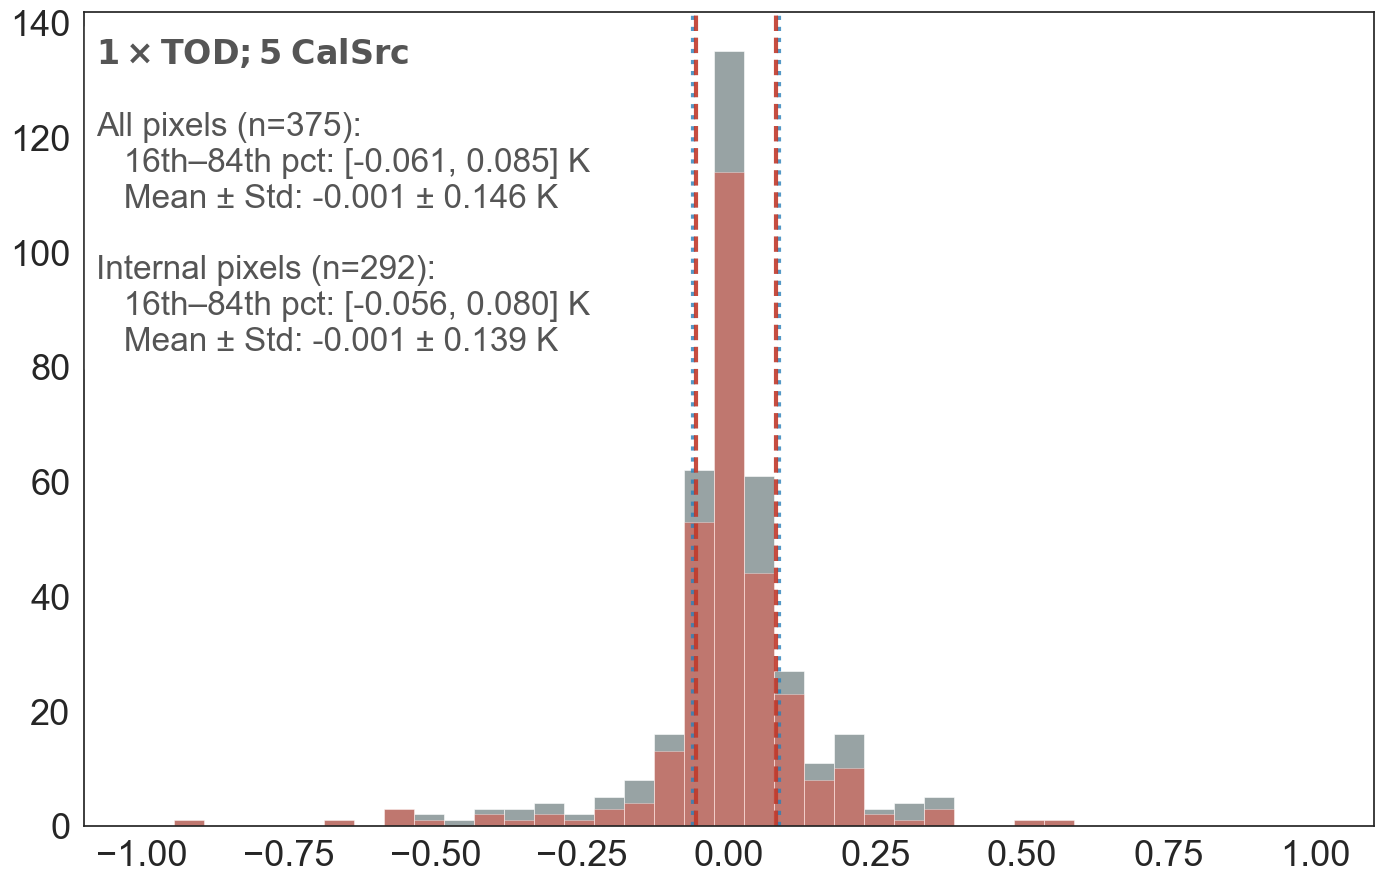

All pixels - Mean: -0.0119, Std: 0.2531, RMS: 0.2534
All pixels - 16th-84th percentile: [-0.0405, 0.0744]
Internal pixels - Mean: -0.0007, Std: 0.1703, RMS: 0.1703
Internal pixels - 16th-84th percentile: [-0.0220, 0.0256]
Plot saved to: figures/GS5_db_Tsky_residual.pdf
Plot saved to: figures/GS5_db_Tsky_residual.pdf


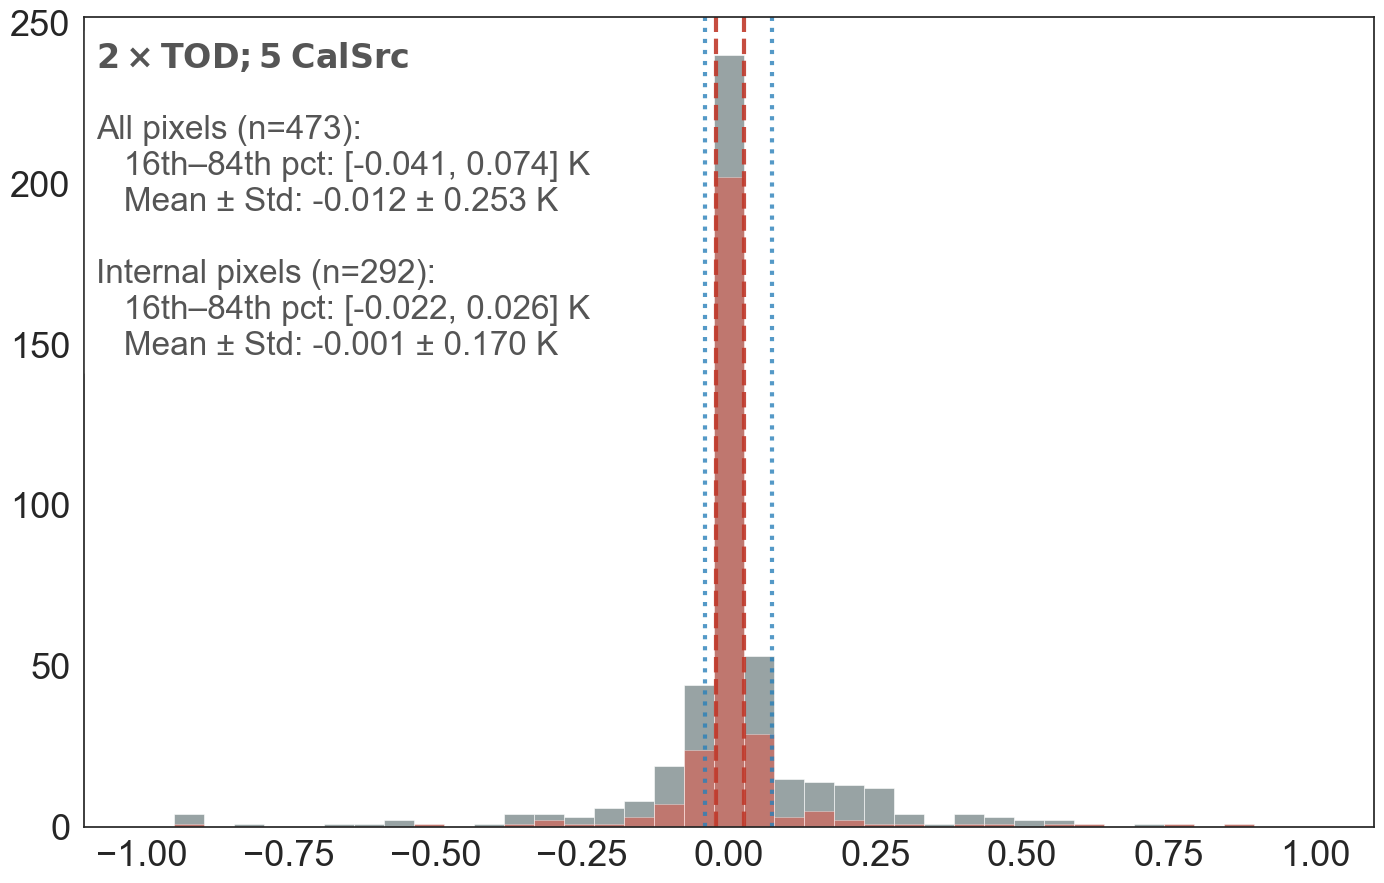

All pixels - Mean: 0.0055, Std: 0.1485, RMS: 0.1486
All pixels - 16th-84th percentile: [-0.0551, 0.0962]
Internal pixels - Mean: 0.0054, Std: 0.1380, RMS: 0.1381
Internal pixels - 16th-84th percentile: [-0.0486, 0.0854]
Plot saved to: figures/GF5_Tsky_residual.pdf
Plot saved to: figures/GF5_Tsky_residual.pdf


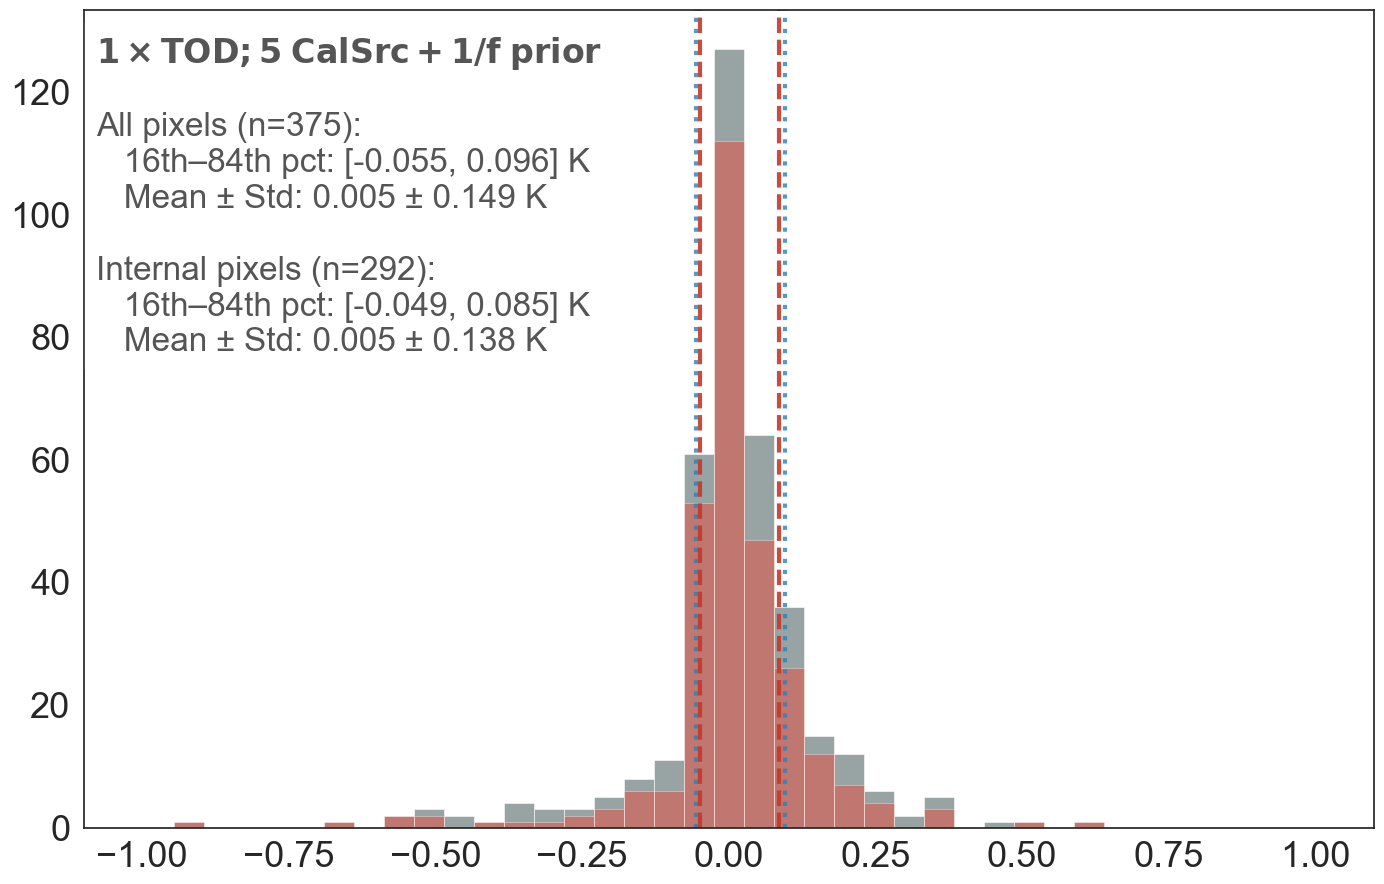

All pixels - Mean: -0.0096, Std: 0.2278, RMS: 0.2280
All pixels - 16th-84th percentile: [-0.0414, 0.0655]
Internal pixels - Mean: -0.0038, Std: 0.1522, RMS: 0.1522
Internal pixels - 16th-84th percentile: [-0.0233, 0.0239]
Plot saved to: figures/GF5_db_Tsky_residual.pdf
Plot saved to: figures/GF5_db_Tsky_residual.pdf


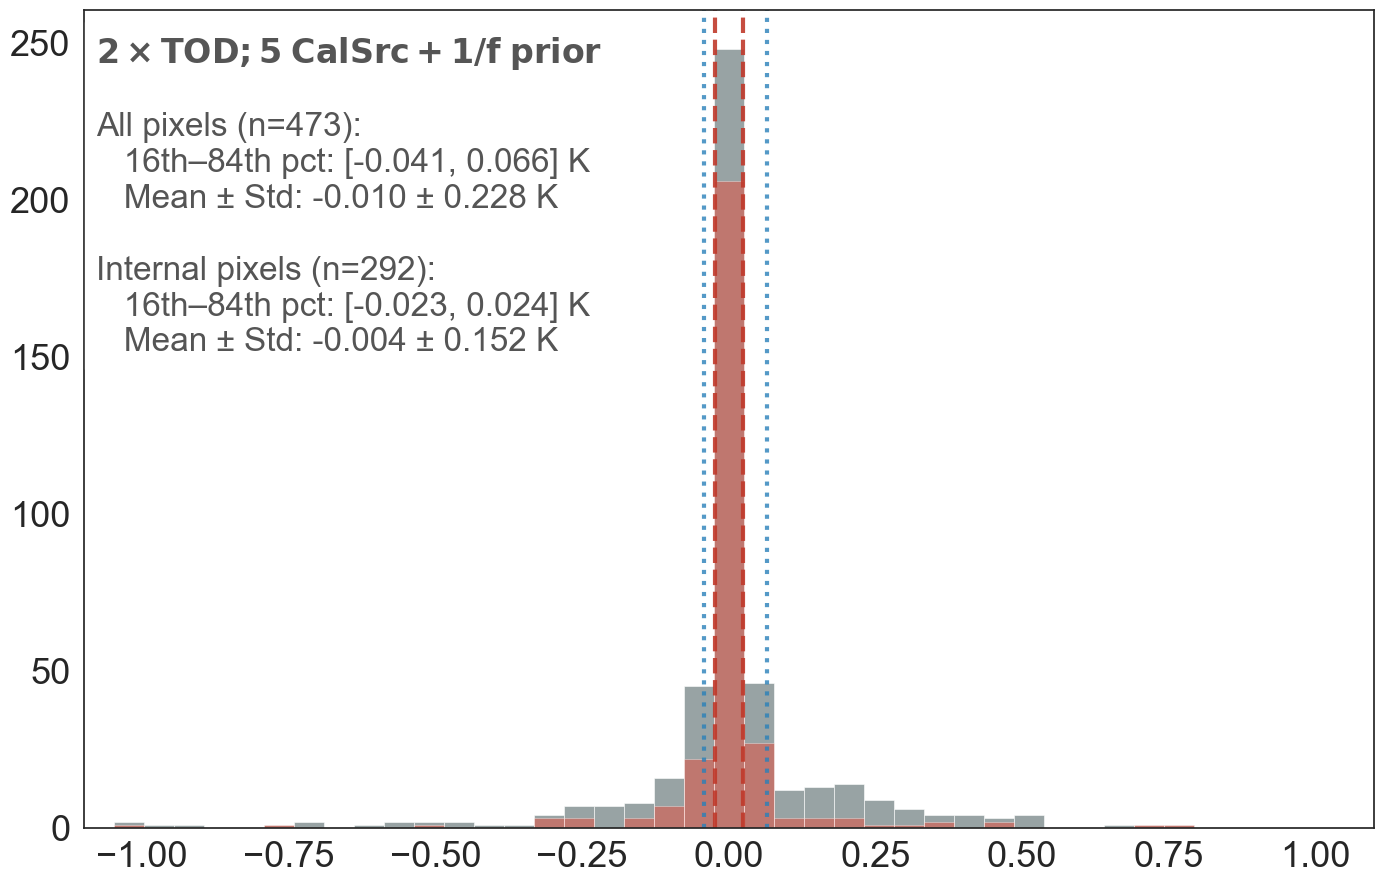

In [106]:
# panel (0,0)
plot_residual_histogram(
    r"1 \times TOD; 1 \; CalSrc",
    GS1_Tsky_residual, 
    GS1_Tsky_residual_common,
    save_path="figures/GS1_Tsky_residual.pdf",
    kde=False,
    figsize=(14, 9),
    legend=True,
    xlim=[-1.1, 1.1]
)

# panel (0,1)
plot_residual_histogram(
    r"2 \times TOD; 1\; CalSrc",
    GS1_db_Tsky_residual,  # Corrected: first argument should be residuals data
    GS1_db_Tsky_residual_common,  # Second argument is common residuals
    save_path="figures/GS1_db_Tsky_residual.pdf",
    kde=False,
    figsize=(14, 9),
    xlim=[-1.1, 1.1]
)

# panel (1,0)
plot_residual_histogram(
    r"1 \times TOD; 5\; CalSrc",
    GS5_Tsky_residual,
    GS5_Tsky_residual_common,
    save_path="figures/GS5_Tsky_residual.pdf",
    kde=False,
    figsize=(14, 9),
    xlim=[-1.1, 1.1]
)

# panel (1,1)
plot_residual_histogram(
    r"2 \times TOD; 5\; CalSrc",
    GS5_db_Tsky_residual,
    GS5_db_Tsky_residual_common,
    save_path="figures/GS5_db_Tsky_residual.pdf",
    kde=False,
    figsize=(14, 9),
    xlim=[-1.1, 1.1]
)

# panel (2,0)
plot_residual_histogram(
    r"1 \times TOD; 5\; CalSrc + 1/f\; prior",
    GSF5_Tsky_residual,
    GSF5_Tsky_residual_common,
    save_path="figures/GF5_Tsky_residual.pdf",
    kde=False,
    figsize=(14, 9),
    xlim=[-1.1, 1.1]
)

# panel (2,1)
plot_residual_histogram(
    r"2 \times TOD; 5\; CalSrc + 1/f \; prior",
    GSF5_db_Tsky_residual,
    GSF5_db_Tsky_residual_common,
    save_path="figures/GF5_db_Tsky_residual.pdf",
    kde=False,
    figsize=(14, 9),
    xlim=[-1.1, 1.1]
)



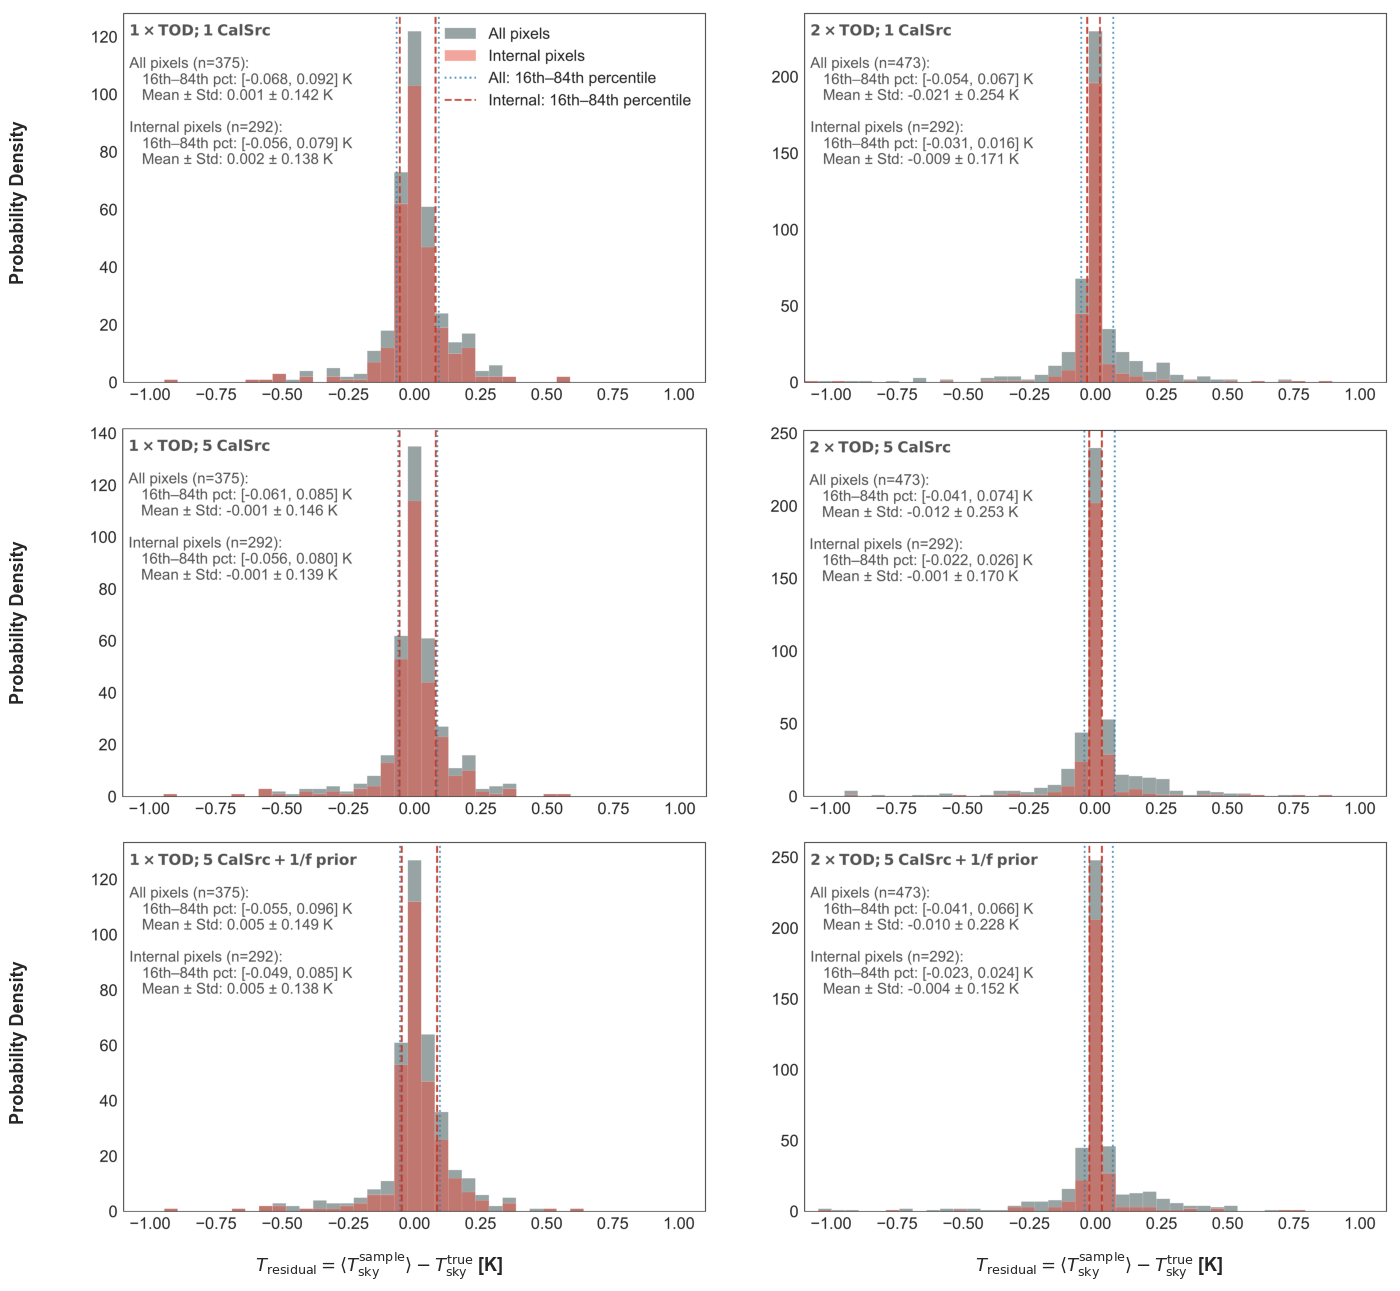

In [107]:
from visualisation import combine_pdfs_to_panels

# Example usage with common labels

residual_pdfs = [
    "figures/GS1_Tsky_residual.pdf",
    "figures/GS1_db_Tsky_residual.pdf", 
    "figures/GS5_Tsky_residual.pdf",
    "figures/GS5_db_Tsky_residual.pdf",
    "figures/GF5_Tsky_residual.pdf",
    "figures/GF5_db_Tsky_residual.pdf"
]

# panel_titles = [
#     "1×TOD; 1 CalSrc",
#     "2×TOD; 1 CalSrc",
#     "1×TOD; 5 CalSrc", 
#     "2×TOD; 5 CalSrc",
#     "1×TOD; 5 CalSrc + 1/f prior",
#     "2×TOD; 5 CalSrc + 1/f prior"
# ]

panel_titles = None

combine_pdfs_to_panels(
    pdf_files=residual_pdfs,
    output_file="figures/combined_residual_histograms.pdf",
    rows=3, cols=2,
    titles=None,
    common_xlabel=r'$T_{\mathrm{residual}} = \langle T^{\mathrm{sample}}_{\mathrm{sky}} \rangle - T_{\mathrm{sky}}^{\mathrm{true}}$ [K]',
    common_ylabel="Probability Density",
    figsize=(16, 14),
    add_panel_labels=True,  # Enable panel labels
    panel_label_fontsize=13,
    ay=0.9, by=0.1, ly=0.01,
    ax=0.9, bx=0.1, lx=0.02,
)

## Produce maps

In [31]:
def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map

def gnomview_patch(map, 
                   pixel_indices, 
                   lon_center, 
                   lat_center,
                   res,
                   sky_min, 
                   sky_max,
                   title=" ",
                   save_path=None, 
                   cmap='jet',
                   cbar=True,
                   xtick=False,
                   ytick=False,
                   unit='K',
                   turn_into_map=True,
                   fts=16,
                   xlabel=None, 
                   ylabel=None):
    NPIX = hp.nside2npix(64)
    if turn_into_map:
        aux_map = np.zeros(NPIX, dtype=float)
        aux_map[pixel_indices] = map
    else:
        aux_map = map
    patch_only_map = view_patch_map(aux_map, pixel_indices)
    hp.gnomview( patch_only_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=220, reso=res, title=title, 
           unit=unit, cmap=cmap, min=sky_min, max=sky_max,
           notext=True,
           coord=['C'], 
           cbar=cbar, 
           badcolor='gray')
    cb = plt.gcf().axes[-1]  # Get the colorbar axis (usually the last one)
    cb.tick_params(labelsize=fts)  # Set the font size to 18 (adjust as needed)
    hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  # Add graticule lines; separation in degrees
    plt.gca().set_facecolor('gray')  # Set background to gray

    # Add axis labels using plt.text
    fig = plt.gcf()
    ax = plt.gca()
    if title and title.strip():  # Only if title is not empty
        ax.set_title(title, fontsize=fts-1, pad=5)

    if cbar:
        if xtick:
            fig.text(0.5, 0.185, str(lon_center)[:7], ha='center', fontsize=fts-1)
        if ytick:
            fig.text(0.045, 0.37, str(lat_center)[:5], va='center', rotation='vertical', fontsize=fts-1)
        if xlabel is not None:
            fig.text(0.5, 0.155, xlabel, ha='center', fontsize=fts-1)
        if ylabel is not None:
            fig.text(0.01, 0.4, ylabel, va='center', rotation='vertical', fontsize=fts-1)
    else:
        if xtick:
            fig.text(0.5, 0.31, str(lon_center)[:7], ha='center', fontsize=fts-1)
        if ytick:
            fig.text(0.045, 0.5, str(lat_center)[:5], va='center', rotation='vertical', fontsize=fts-1)
        if xlabel is not None:
            fig.text(0.5, 0.28, xlabel, ha='center', fontsize=fts-1)
        if ylabel is not None:
            fig.text(0.01, 0.5, ylabel, va='center', rotation='vertical', fontsize=fts-1)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', 
                pad_inches=0.1)
    
    pass

In [32]:
theta, phi = hp.pix2ang(nside, pixel_indices_setting)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


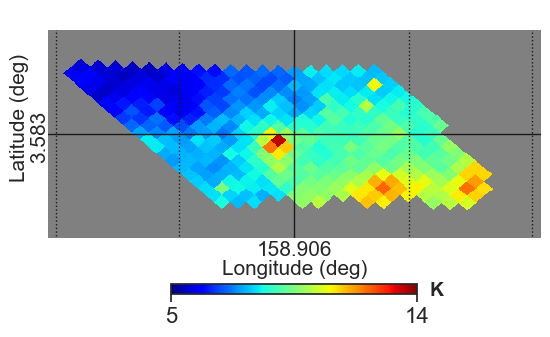

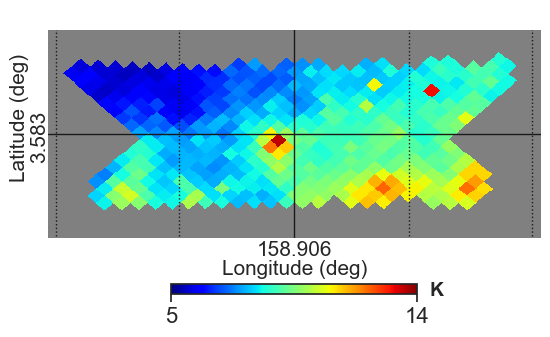

In [ ]:
gnomview_patch(sky_params_setting, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               cbar=True,
               xtick=True,
               ytick=True,
               save_path="figures/true_sky_1.pdf",
               turn_into_map=True,
               xlabel='Longitude (deg)',
               ylabel='Latitude (deg)',
               )

gnomview_patch(sky_params, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               cbar=True,
               xtick=True,
               ytick=True,
               xlabel='Longitude (deg)',
               ylabel='Latitude (deg)',
               save_path="figures/true_sky_2.pdf",
               turn_into_map=True,
               )

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


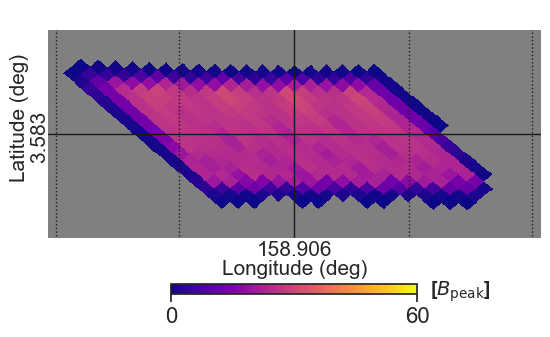

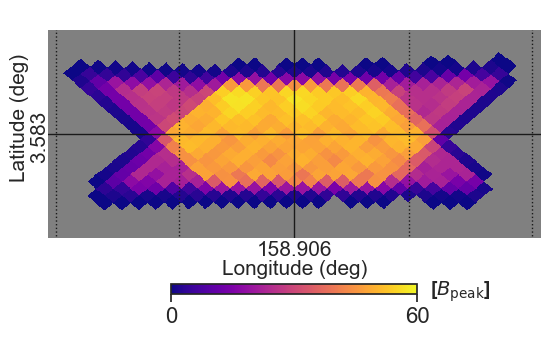

In [34]:
gnomview_patch(integrated_beam_setting, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0, 
               60,
               cmap='plasma',
               unit=r'[$B_{\rm peak}$]',
               xtick=True,
               ytick=True,
               xlabel='Longitude (deg)',
               ylabel='Latitude (deg)',
               save_path="figures/integrated_beam_1.pdf",
               turn_into_map=False
               )

gnomview_patch(integrated_beam, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0, 
               60,
               xtick=True,
               ytick=True,
               xlabel='Longitude (deg)',
               ylabel='Latitude (deg)',
               cmap='plasma',
               unit=r'[$B_{\rm peak}$]',
               save_path="figures/integrated_beam_2.pdf",
               turn_into_map=False
               )

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

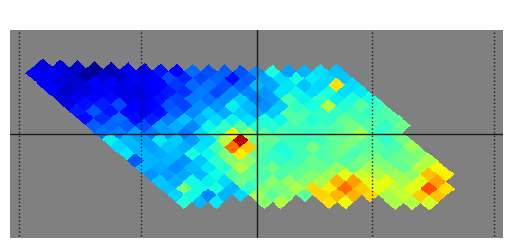

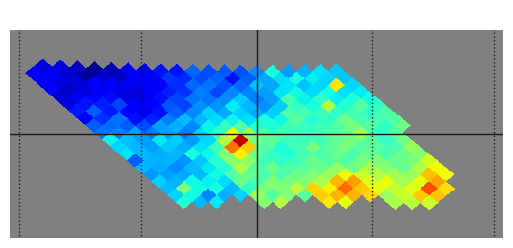

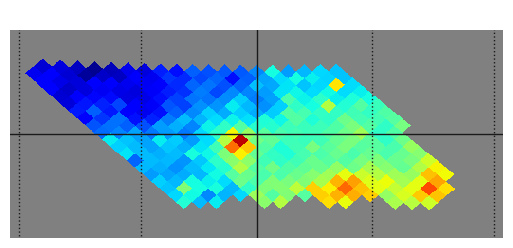

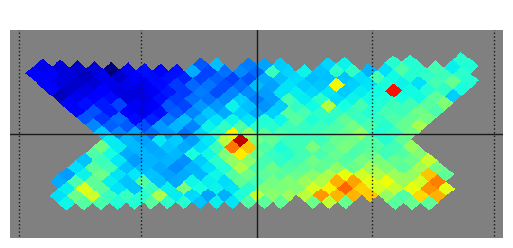

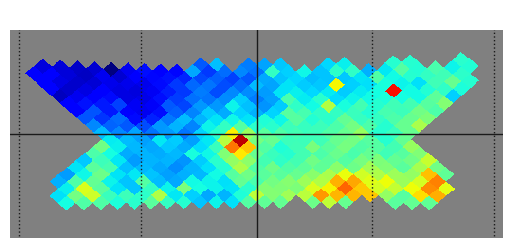

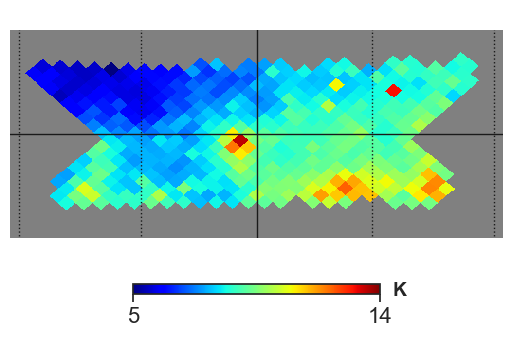

In [35]:
# Panel titles (matching your comments in the original code)
titles = [
    r'1 $\times$ TOD; 1 CalSrc',                    # row 0
    r'1 $\times$ TOD; 5 CalSrc',                    # row 1
    r'1 $\times$ TOD; 5 CalSrc + 1/f prior',       # row 2
    r'2 $\times$ TOD; 1 CalSrc',                    # row 3
    r'2 $\times$ TOD; 5 CalSrc',                    # row 4
    r'2 $\times$ TOD; 5 CalSrc + 1/f prior',       # row 5
]

titles = [" "]*6

gnomview_patch(GS1_Tsky_mean, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[0],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS1_mean_map.pdf"
               )
gnomview_patch(GS5_Tsky_mean, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[1],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS5_mean_map.pdf"
               )
gnomview_patch(GSF5_Tsky_mean, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[2],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,    
            #    ytick=True,
               save_path="figures/GSF5_mean_map.pdf"
               )
gnomview_patch(GS1_db_Tsky_mean, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[3],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS1_db_mean_map.pdf"
               )
gnomview_patch(GS5_db_Tsky_mean, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[4],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS5_db_mean_map.pdf"
               )
gnomview_patch(GSF5_db_Tsky_mean, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5,
               14,
               title=titles[5],
               cbar=True,
            #    xtick=True,
            #    ytick=True,
            #    xlabel="Longitude",
            #    ylabel="Latitude ",
               save_path="figures/GSF5_db_mean_map.pdf"
               )


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

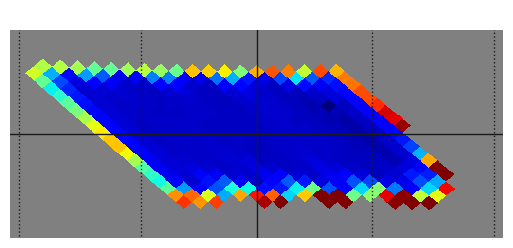

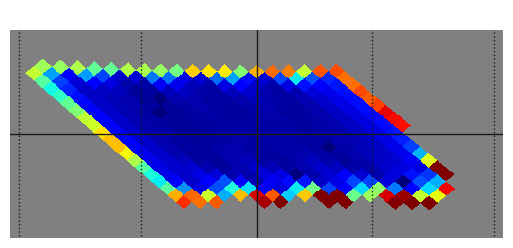

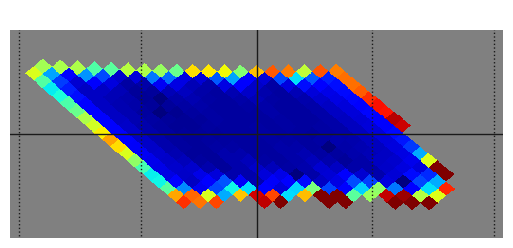

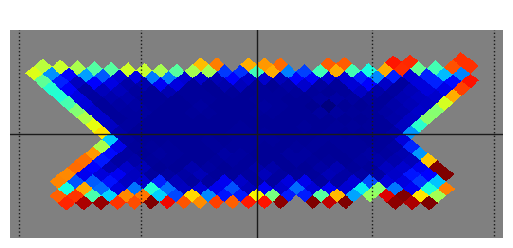

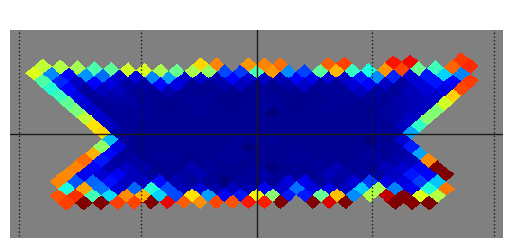

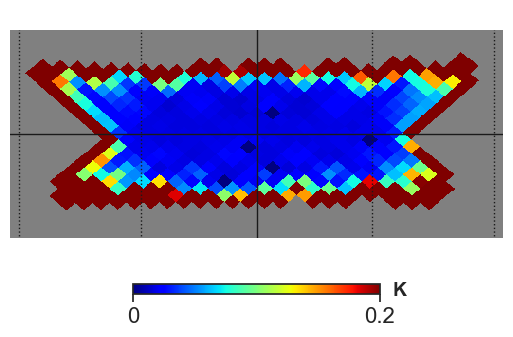

In [36]:
gnomview_patch(GS1_Tsky_std, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0, 
               1,
               title=titles[0],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_std_map.pdf"
               )
gnomview_patch(GS5_Tsky_std, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0, 
               1,
               title=titles[1],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS5_std_map.pdf"
               )
gnomview_patch(GSF5_Tsky_std, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0, 
               1,
               title=titles[2],
               cbar=False,
               xtick=False,
               xlabel=None,    
               ytick=False,
               ylabel=None,
               save_path="figures/GSF5_std_map.pdf"
               )
gnomview_patch(GS1_db_Tsky_std, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0, 
               1,
               title=titles[3],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_db_std_map.pdf"
               )
gnomview_patch(GS5_db_Tsky_std, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0, 
               1,
               title=titles[4],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS5_db_std_map.pdf"
               )
gnomview_patch(GSF5_db_Tsky_std, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0,
               0.2,
               title=titles[5],
               cbar=True,
               xtick=False,
               ytick=False,
               xlabel=None,
               ylabel=None,
               save_path="figures/GSF5_db_std_map.pdf"
               )


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

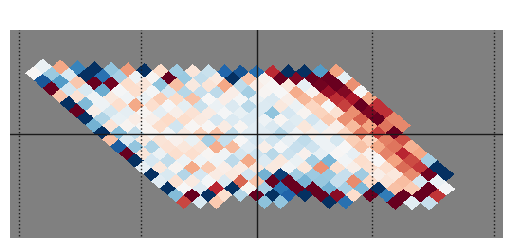

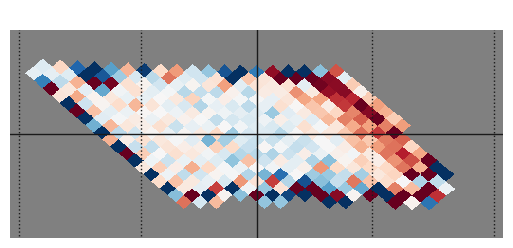

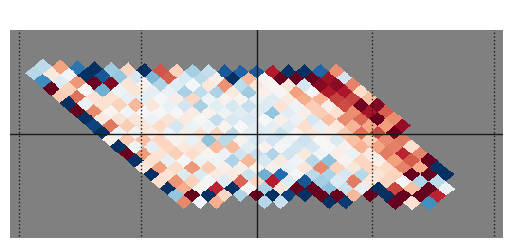

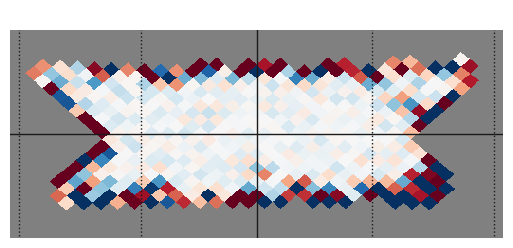

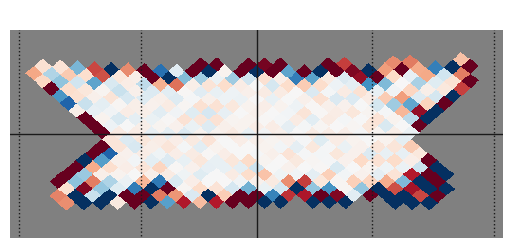

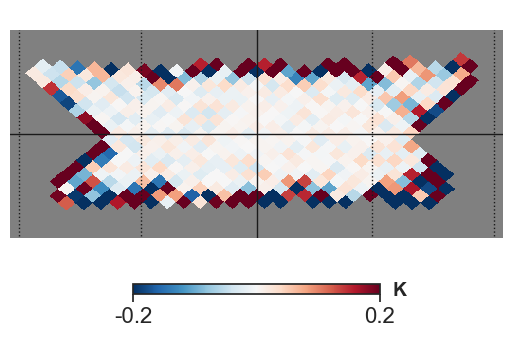

In [37]:
gnomview_patch(GS1_Tsky_residual, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               -0.2, 
               0.2,
               title=titles[0],
               cmap='RdBu_r',
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_err_map.pdf"
               )
gnomview_patch(GS5_Tsky_residual, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               -0.2, 
               0.2,
               title=titles[1],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS5_err_map.pdf"
               )
gnomview_patch(GSF5_Tsky_residual, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               -0.2, 
               0.2,
               title=titles[2],
               cbar=False,
               xtick=False,
               xlabel=None,    
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GSF5_err_map.pdf"
               )
gnomview_patch(GS1_db_Tsky_residual, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -0.2,
               0.2,
               title=titles[3],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS1_db_err_map.pdf"
               )
gnomview_patch(GS5_db_Tsky_residual, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -0.2,
               0.2,
               title=titles[4],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS5_db_err_map.pdf"
               )
gnomview_patch(GSF5_db_Tsky_residual, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -0.2,
               0.2,
               title=titles[5],
               cbar=True,
               xtick=None,
               ytick=False,
               xlabel=None,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GSF5_db_err_map.pdf"
               )


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

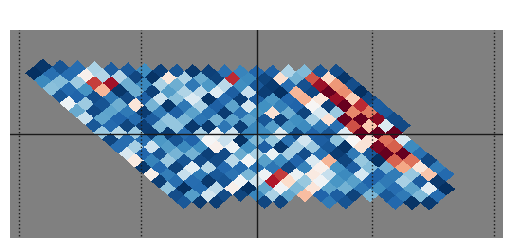

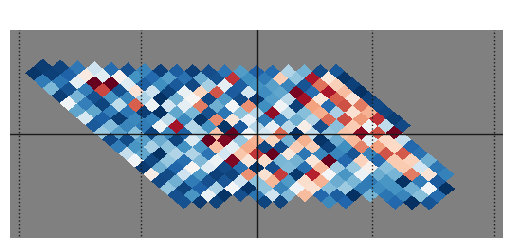

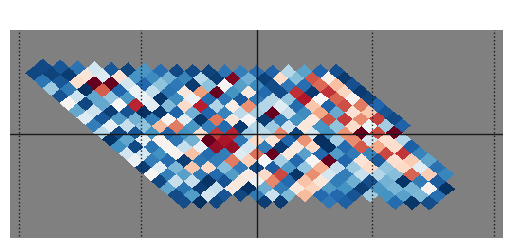

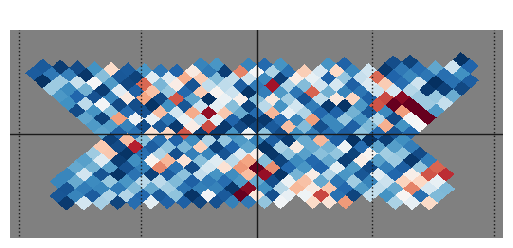

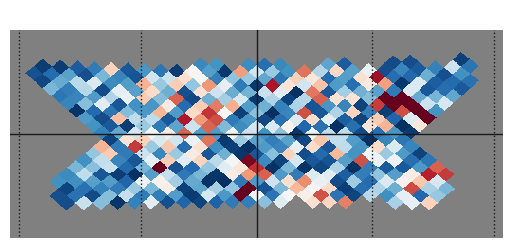

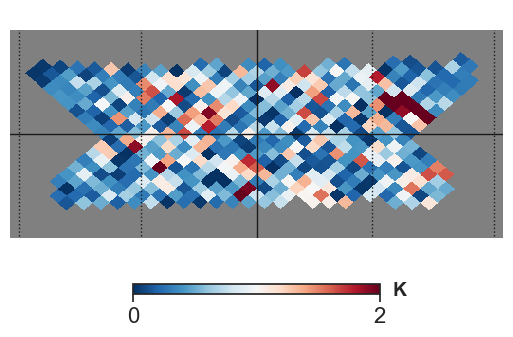

In [38]:
gnomview_patch(np.abs(GS1_Tsky_residual / GS1_Tsky_std), 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0.0, 
               2.0,
               title=titles[0],
               cmap='RdBu_r',
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_zscore_map.pdf"
               )
gnomview_patch(np.abs(GS5_Tsky_residual / GS5_Tsky_std), 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0.0, 
               2.0,
               title=titles[1],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS5_zscore_map.pdf"
               )
gnomview_patch(np.abs(GSF5_Tsky_residual / GSF5_Tsky_std), 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0.0, 
               2.0,
               title=titles[2],
               cbar=False,
               xtick=False,
               xlabel=None,    
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GSF5_zscore_map.pdf"
               )
gnomview_patch(np.abs(GS1_db_Tsky_residual / GS1_db_Tsky_std), 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0.0,
               2.0,
               title=titles[3],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS1_db_zscore_map.pdf"
               )
gnomview_patch(np.abs(GS5_db_Tsky_residual / GS5_db_Tsky_std), 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0.0,
               2.0,
               title=titles[4],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS5_db_zscore_map.pdf"
               )
gnomview_patch(np.abs(GSF5_db_Tsky_residual / GSF5_db_Tsky_std), 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0.0,
               2.0,
               title=titles[5],
               cbar=True,
               xtick=None,
               ytick=False,
               xlabel=None,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GSF5_db_zscore_map.pdf"
               )


## Generate posterior median as sky estimation

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

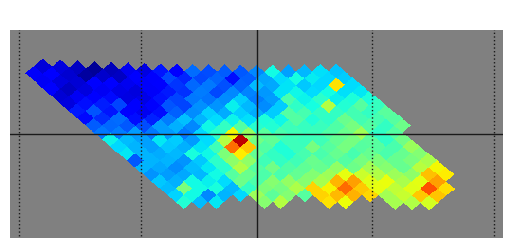

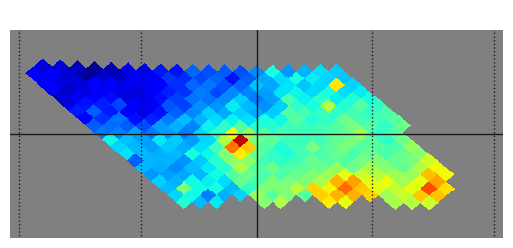

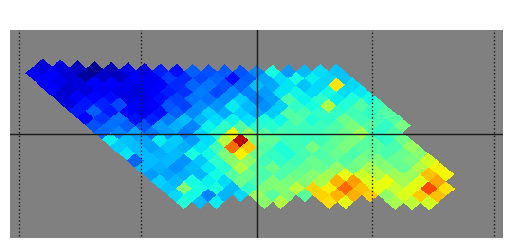

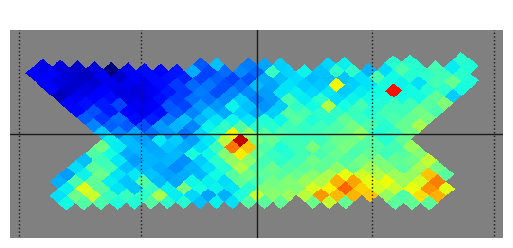

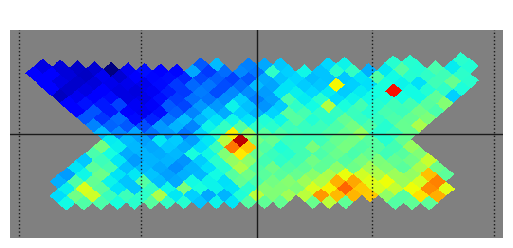

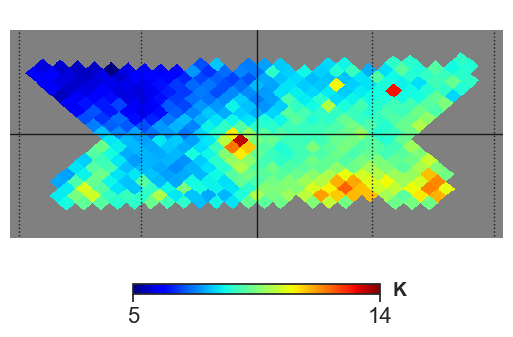

In [39]:
# Panel titles (matching your comments in the original code)
titles = [
    r'1 $\times$ TOD; 1 CalSrc',                    # row 0
    r'1 $\times$ TOD; 5 CalSrc',                    # row 1
    r'1 $\times$ TOD; 5 CalSrc + 1/f prior',       # row 2
    r'2 $\times$ TOD; 1 CalSrc',                    # row 3
    r'2 $\times$ TOD; 5 CalSrc',                    # row 4
    r'2 $\times$ TOD; 5 CalSrc + 1/f prior',       # row 5
]

titles = [" "]*6

gnomview_patch(GS1_Tsky_median, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[0],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS1_median_map.pdf"
               )
gnomview_patch(GS5_Tsky_median, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[1],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS5_median_map.pdf"
               )
gnomview_patch(GSF5_Tsky_median, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[2],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,    
            #    ytick=True,
               save_path="figures/GSF5_median_map.pdf"
               )
gnomview_patch(GS1_db_Tsky_median, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[3],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS1_db_median_map.pdf"
               )
gnomview_patch(GS5_db_Tsky_median, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               title=titles[4],
               cbar=False,
            #    xtick=False,
            #    xlabel=None,
            #    ytick=True,
               save_path="figures/GS5_db_median_map.pdf"
               )
gnomview_patch(GSF5_db_Tsky_median, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5,
               14,
               title=titles[5],
               cbar=True,
            #    xtick=True,
            #    ytick=True,
            #    xlabel="Longitude",
            #    ylabel="Latitude ",
               save_path="figures/GSF5_db_median_map.pdf"
               )


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

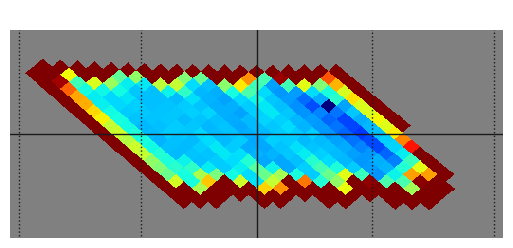

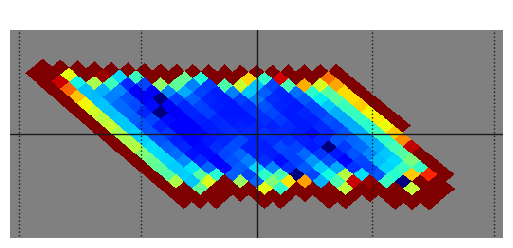

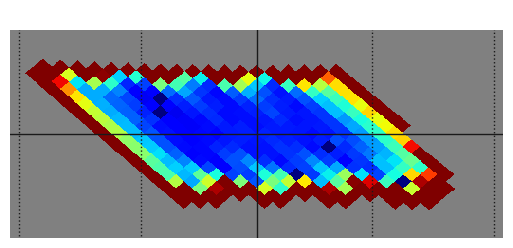

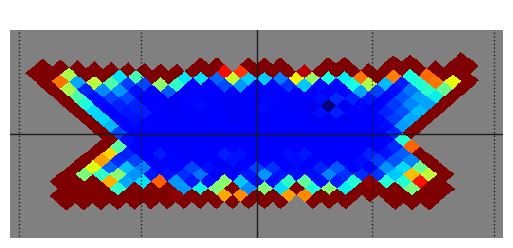

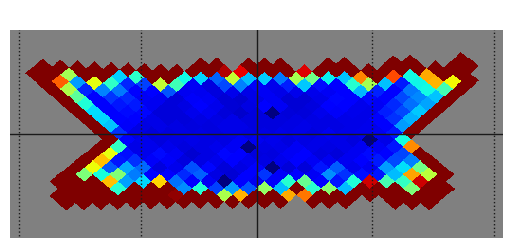

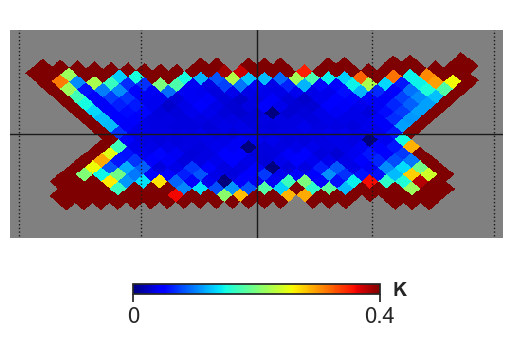

In [45]:
gnomview_patch(GS1_Tsky_ci_68, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0, 
               0.4,
               title=titles[0],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_ci_map.pdf"
               )

gnomview_patch(GS5_Tsky_ci_68, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0, 
               0.4,
               title=titles[1],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS5_ci_map.pdf"
               )
gnomview_patch(GSF5_Tsky_ci_68, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0,
               0.4,
               title=titles[2],
               cbar=False,
               xtick=False,
               xlabel=None,    
               ytick=False,
               ylabel=None,
               save_path="figures/GSF5_ci_map.pdf"
               )
gnomview_patch(GS1_db_Tsky_ci_68, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0,
               0.4,
               title=titles[3],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_db_ci_map.pdf"
               )
gnomview_patch(GS5_db_Tsky_ci_68, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0,
               0.4,
               title=titles[4],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS5_db_ci_map.pdf"
               )
gnomview_patch(GSF5_db_Tsky_ci_68, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0,
               0.4,
               title=titles[5],
               cbar=True,
               xtick=False,
               ytick=False,
               xlabel=None,
               ylabel=None,
               save_path="figures/GSF5_db_ci_map.pdf"
               )


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

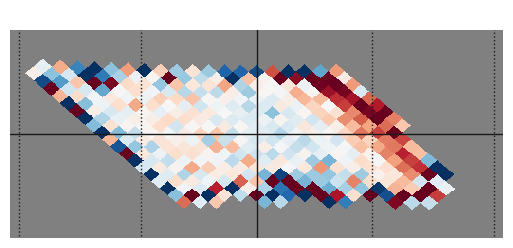

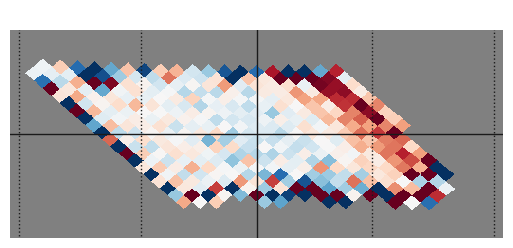

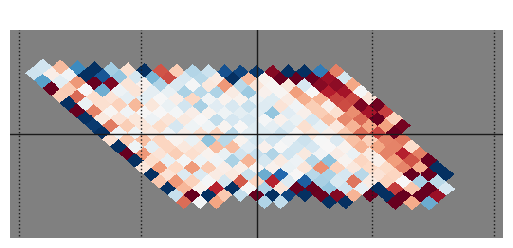

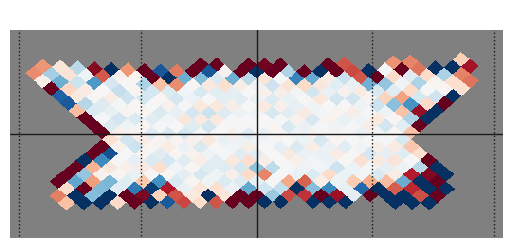

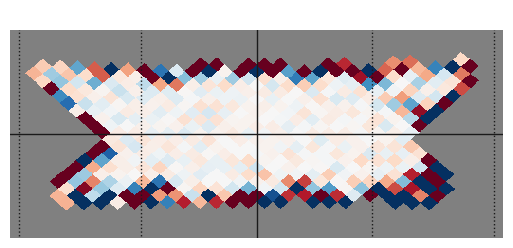

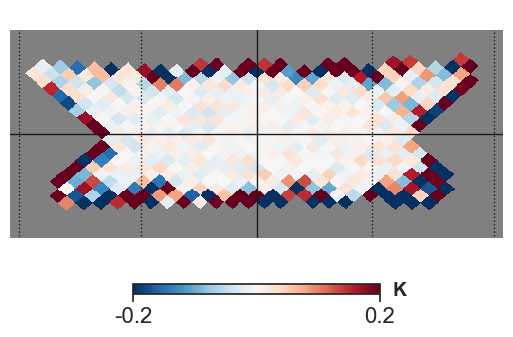

In [46]:
gnomview_patch(GS1_Tsky_median_residual, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               -0.2, 
               0.2,
               title=titles[0],
               cmap='RdBu_r',
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_med_err_map.pdf"
               )
gnomview_patch(GS5_Tsky_median_residual, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               -0.2, 
               0.2,
               title=titles[1],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS5_med_err_map.pdf"
               )
gnomview_patch(GSF5_Tsky_median_residual, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               -0.2, 
               0.2,
               title=titles[2],
               cbar=False,
               xtick=False,
               xlabel=None,    
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GSF5_med_err_map.pdf"
               )
gnomview_patch(GS1_db_Tsky_median_residual, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -0.2,
               0.2,
               title=titles[3],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS1_db_med_err_map.pdf"
               )
gnomview_patch(GS5_db_Tsky_median_residual, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -0.2,
               0.2,
               title=titles[4],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GS5_db_med_err_map.pdf"
               )
gnomview_patch(GSF5_db_Tsky_median_residual, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -0.2,
               0.2,
               title=titles[5],
               cbar=True,
               xtick=None,
               ytick=False,
               xlabel=None,
               ylabel=None,
               cmap='RdBu_r',
               save_path="figures/GSF5_db_med_err_map.pdf"
               )


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are n

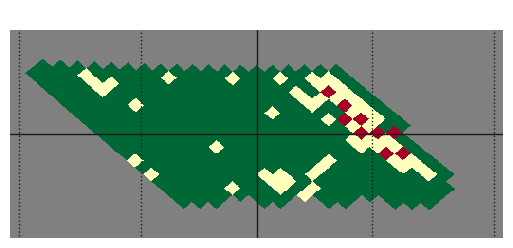

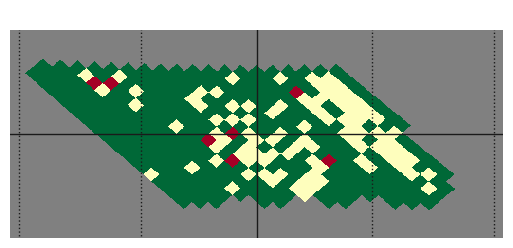

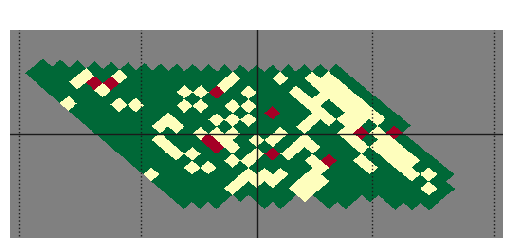

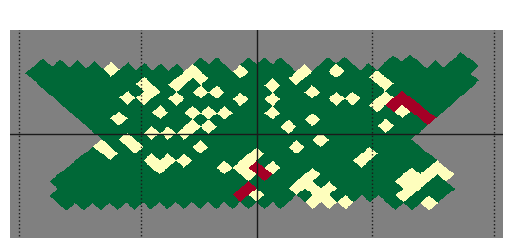

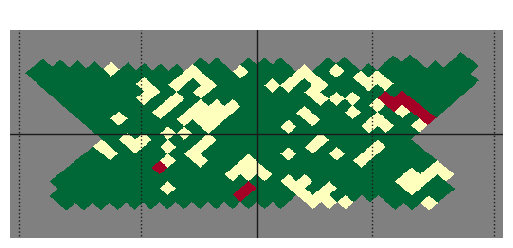

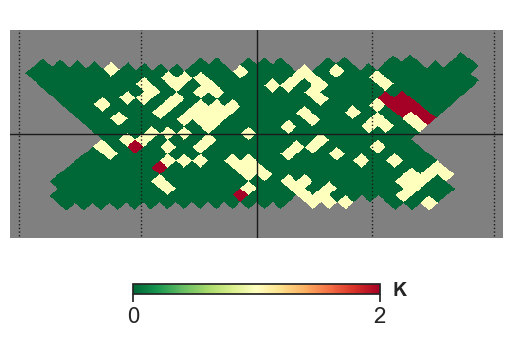

In [56]:
gnomview_patch(GS1_Tsky_coverage, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0.0, 
               2.0,
               title=titles[0],
               cmap='RdYlGn_r',
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path="figures/GS1_coverage_map.pdf"
               )
gnomview_patch(GS5_Tsky_coverage, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0.0, 
               2.0,
               title=titles[1],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdYlGn_r',
               save_path="figures/GS5_coverage_map.pdf"
               )
gnomview_patch(GSF5_Tsky_coverage, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0.0, 
               2.0,
               title=titles[2],
               cbar=False,
               xtick=False,
               xlabel=None,    
               ytick=False,
               ylabel=None,
               cmap='RdYlGn_r',
               save_path="figures/GSF5_coverage_map.pdf"
               )
gnomview_patch(GS1_db_Tsky_coverage, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0.0,
               2.0,
               title=titles[3],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdYlGn_r',
               save_path="figures/GS1_db_coverage_map.pdf"
               )
gnomview_patch(GS5_db_Tsky_coverage, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0.0,
               2.0,
               title=titles[4],
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               cmap='RdYlGn_r',  # Red for violations, green for good
               save_path="figures/GS5_db_coverage_map.pdf"
               )
gnomview_patch(GSF5_db_Tsky_coverage, 
               pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0.0,
               2.0,
               title=titles[5],
               cbar=True,
               xtick=None,
               ytick=False,
               xlabel=None,
               ylabel=None,
               cmap='RdYlGn_r',  # Red for violations, green for good
               save_path="figures/GSF5_db_coverage_map.pdf"
               )


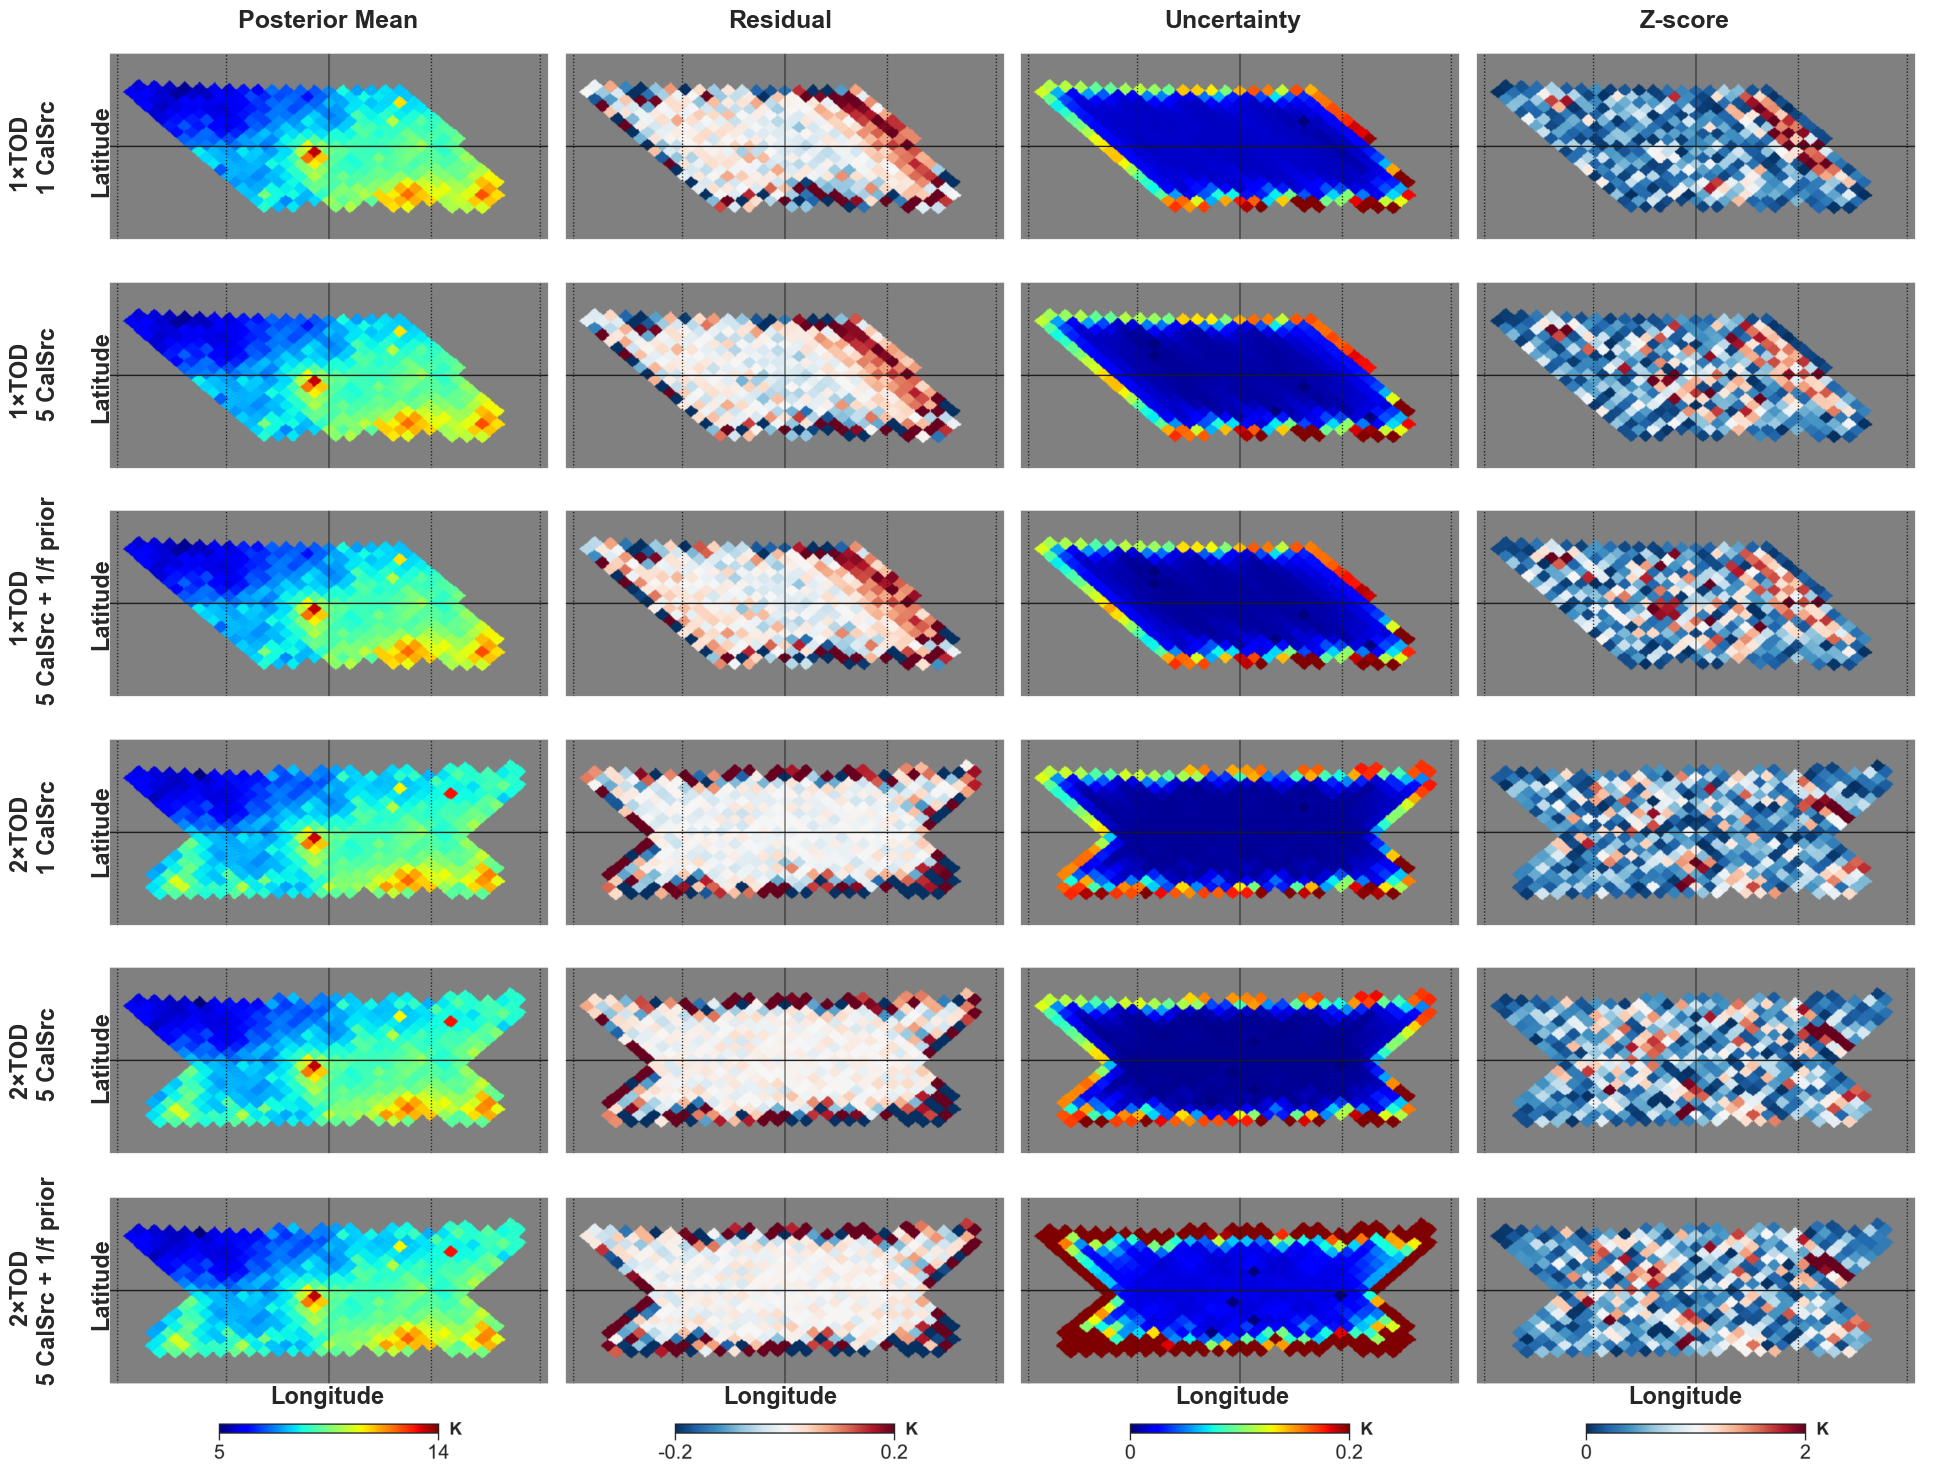

In [ ]:
# Example usage with common labels

map_pdfs = [
    "figures/GS1_mean_map.pdf",
    "figures/GS1_err_map.pdf",
    "figures/GS1_std_map.pdf",
    "figures/GS1_zscore_map.pdf",
    "figures/GS5_mean_map.pdf",
    "figures/GS5_err_map.pdf",
    "figures/GS5_std_map.pdf",
    "figures/GS5_zscore_map.pdf",
    "figures/GSF5_mean_map.pdf",
    "figures/GSF5_err_map.pdf",
    "figures/GSF5_std_map.pdf",
    "figures/GSF5_zscore_map.pdf",
    "figures/GS1_db_mean_map.pdf",
    "figures/GS1_db_err_map.pdf",
    "figures/GS1_db_std_map.pdf",
    "figures/GS1_db_zscore_map.pdf",
    "figures/GS5_db_mean_map.pdf",
    "figures/GS5_db_err_map.pdf",
    "figures/GS5_db_std_map.pdf",
    "figures/GS5_db_zscore_map.pdf",
    "figures/GSF5_db_mean_map.pdf",
    "figures/GSF5_db_err_map.pdf",
    "figures/GSF5_db_std_map.pdf",
    "figures/GSF5_db_zscore_map.pdf",
    "figures/hp_wiener_estimation.pdf",
    "figures/hp_wiener_residual.pdf",
    "figures/hp_wiener_uncertainty.pdf",
    "figures/hp_wiener_zscore.pdf"
]



panel_titles = None


import os
def combine_pdfs_to_panels_v2(pdf_files, rows, cols, figsize=(16, 12), 
                          output_file=None, 
                          titles=None, suptitle=None, dpi=300, 
                          col_labels=None, row_labels=None, 
                          add_panel_labels=True, panel_label_fontsize=16,
                          ya=1., yb=0., yl=0.0,
                          xa=1., xb=0., xl=0.0,
                          map_names = ['Posterior Mean', 'Residual', 'Uncertainty', 'Z-score']):
    """
    Combine multiple PDF files into a single PDF with panels arranged in rows and columns.
    
    Parameters:
    -----------
    pdf_files : list of str
        List of PDF file paths to combine
    output_file : str
        Output PDF file path
    rows : int
        Number of rows in the panel layout
    cols : int
        Number of columns in the panel layout
    figsize : tuple
        Figure size (width, height) in inches
    titles : list of str, optional
        List of titles for each panel
    suptitle : str, optional
        Main title for the entire figure
    dpi : int
        DPI for the output PDF
    common_xlabel : str, optional
        Common x-axis label for all panels
    common_ylabel : str, optional
        Common y-axis label for all panels
    label_fontsize : int
        Font size for common axis labels
    add_panel_labels : bool
        Whether to add panel labels (a, b, c, etc.)
    panel_label_fontsize : int
        Font size for panel labels
    """
    
    # Verify we have the right number of files
    expected_panels = rows * cols
    if len(pdf_files) != expected_panels:
        raise ValueError(f"Expected {expected_panels} PDF files for {rows}x{cols} layout, got {len(pdf_files)}")
    
    # Convert PDFs to images first (using pdf2image library)
    try:
        from pdf2image import convert_from_path
    except ImportError:
        raise ImportError("Please install pdf2image: pip install pdf2image")
    
    # Create the combined figure with adjustable height ratios
    fig = plt.figure(figsize=figsize)
    
    # Calculate height ratios based on image aspect ratios
    height_ratios = []
    for i in range(0, len(pdf_files), cols):
        row_images = pdf_files[i:i+cols]
        row_heights = []
        
        for pdf_file in row_images:
            try:
                images = convert_from_path(pdf_file, dpi=200, first_page=1, last_page=1)
                img_array = np.array(images[0])
                aspect_ratio = img_array.shape[0] / img_array.shape[1]  # height/width
                row_heights.append(aspect_ratio)
            except:
                row_heights.append(1.0)  # default aspect ratio
        
        # Use the maximum height in this row to ensure alignment
        height_ratios.append(max(row_heights))
    
    # Create subplots with custom height ratios
    gs = fig.add_gridspec(rows, cols, height_ratios=height_ratios, hspace=0., wspace=0.)
    axes = []
    for i in range(rows):
        for j in range(cols):
            ax = fig.add_subplot(gs[i, j])
            axes.append(ax)
    
    # Process each PDF file
    for i, pdf_file in enumerate(pdf_files):
        if not os.path.exists(pdf_file):
            print(f"Warning: File {pdf_file} not found, skipping...")
            continue
            
        # Convert PDF to image
        try:
            images = convert_from_path(pdf_file, dpi=200, first_page=1, last_page=1)
            img_array = np.array(images[0])
            
            # Display the image with aspect='equal' to maintain aspect ratio
            axes[i].imshow(img_array, aspect='equal')
            axes[i].axis('off')
            
            # Add title if provided
            if titles and i < len(titles) and titles[i]:
                axes[i].set_title(titles[i], fontsize=12, pad=10)
                
        except Exception as e:
            print(f"Error processing {pdf_file}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading\n{os.path.basename(pdf_file)}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Add main title if provided
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=0.95)
    
    # Adjust layout to make room for common labels and panel labels
    plt.tight_layout()
    if suptitle:
        plt.subplots_adjust(top=0.9)
    
    # Adjust margins for labels
    left_margin = 0.05
    bottom_margin = 0.05

    # Extra space for panel labels
    if add_panel_labels:
        left_margin += 0.03  # Extra space for row labels
        bottom_margin += 0.03  # Extra space for column labels
    
    plt.subplots_adjust(left=left_margin, bottom=bottom_margin)
    


    # Add panel labels
    if add_panel_labels:
        
        # Row labels  
        for i, label in enumerate(row_labels):
            y_pos = ya * (1 - (i + 0.5) / rows) + yb # Center vertically for each row
            fig.text(left_margin - yl, y_pos, f'{label}', 
                    ha='center', va='center', 
                    fontsize=panel_label_fontsize, weight='bold', rotation='vertical')
        

        
        for j, label in enumerate(col_labels):
            x_pos = xa * ((j + 0.5) / cols) + xb  # Use ax_param instead of ax
            fig.text(x_pos, bottom_margin - xl, f'{label}', 
                    ha='center', va='center', 
                    fontsize=panel_label_fontsize, weight='bold')
            fig.text(x_pos, 1 - 0.01, map_names[j], 
                    ha='center', va='center', 
                    fontsize=panel_label_fontsize + 1, weight='bold')
    
    # Save the combined figure
    if output_file is not None:
        plt.savefig(output_file, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    pass


panel_titles = [
    "1×TOD \n 1 CalSrc" + "\n\n" + "Latitude",
    "1×TOD \n 5 CalSrc" + "\n\n" + "Latitude",
    "1×TOD \n 5 CalSrc + 1/f prior" + "\n\n" + "Latitude",
    "2×TOD \n 1 CalSrc" + "\n\n" + "Latitude",
    "2×TOD \n 5 CalSrc" + "\n\n" + "Latitude",
    "2×TOD \n 5 CalSrc + 1/f prior" + "\n\n" + "Latitude"
]

combine_pdfs_to_panels_v2(
    pdf_files=map_pdfs,
    output_file="figures/combined_maps.pdf",
    rows=6, cols=4,
    titles=None,
    col_labels=['Longitude']*4,
    row_labels=panel_titles,
    figsize=(20, 16),
    # add_panel_labels=True,  # Enable panel labels
    panel_label_fontsize=17,
    ya=0.85, yb=0.13, yl=0.02,
    xa=0.905, xb=0.08, xl=-0.05,
)

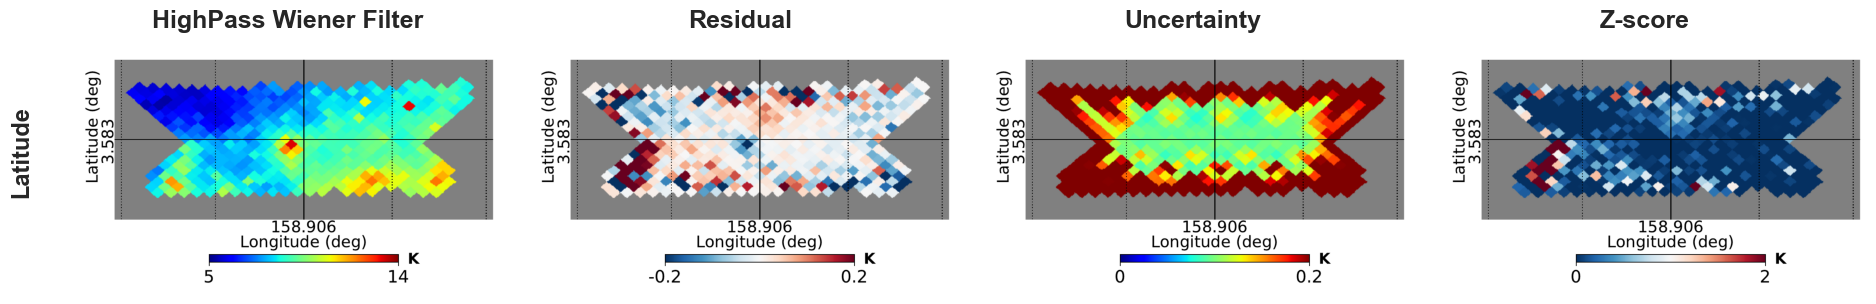

In [113]:
# Example usage with common labels

map_pdfs = [
    "figures/hp_wiener_estimation.pdf",
    "figures/hp_wiener_residual.pdf",
    "figures/hp_wiener_uncertainty.pdf",
    "figures/hp_wiener_zscore.pdf"
]



panel_titles = [
    "Latitude"
]

combine_pdfs_to_panels_v2(
    pdf_files=map_pdfs,
    output_file="figures/combined_wiener_maps.pdf",
    rows=1, cols=4,
    titles=None,
    col_labels=['']*4,
    row_labels=panel_titles,
    figsize=(20, 3),
    # add_panel_labels=True,  # Enable panel labels
    panel_label_fontsize=17,
    ya=0.85, yb=0.13, yl=0.02,
    xa=0.905, xb=0.08, xl=-0.05,
    map_names = ['HighPass Wiener Filter', 'Residual', 'Uncertainty', 'Z-score']
)

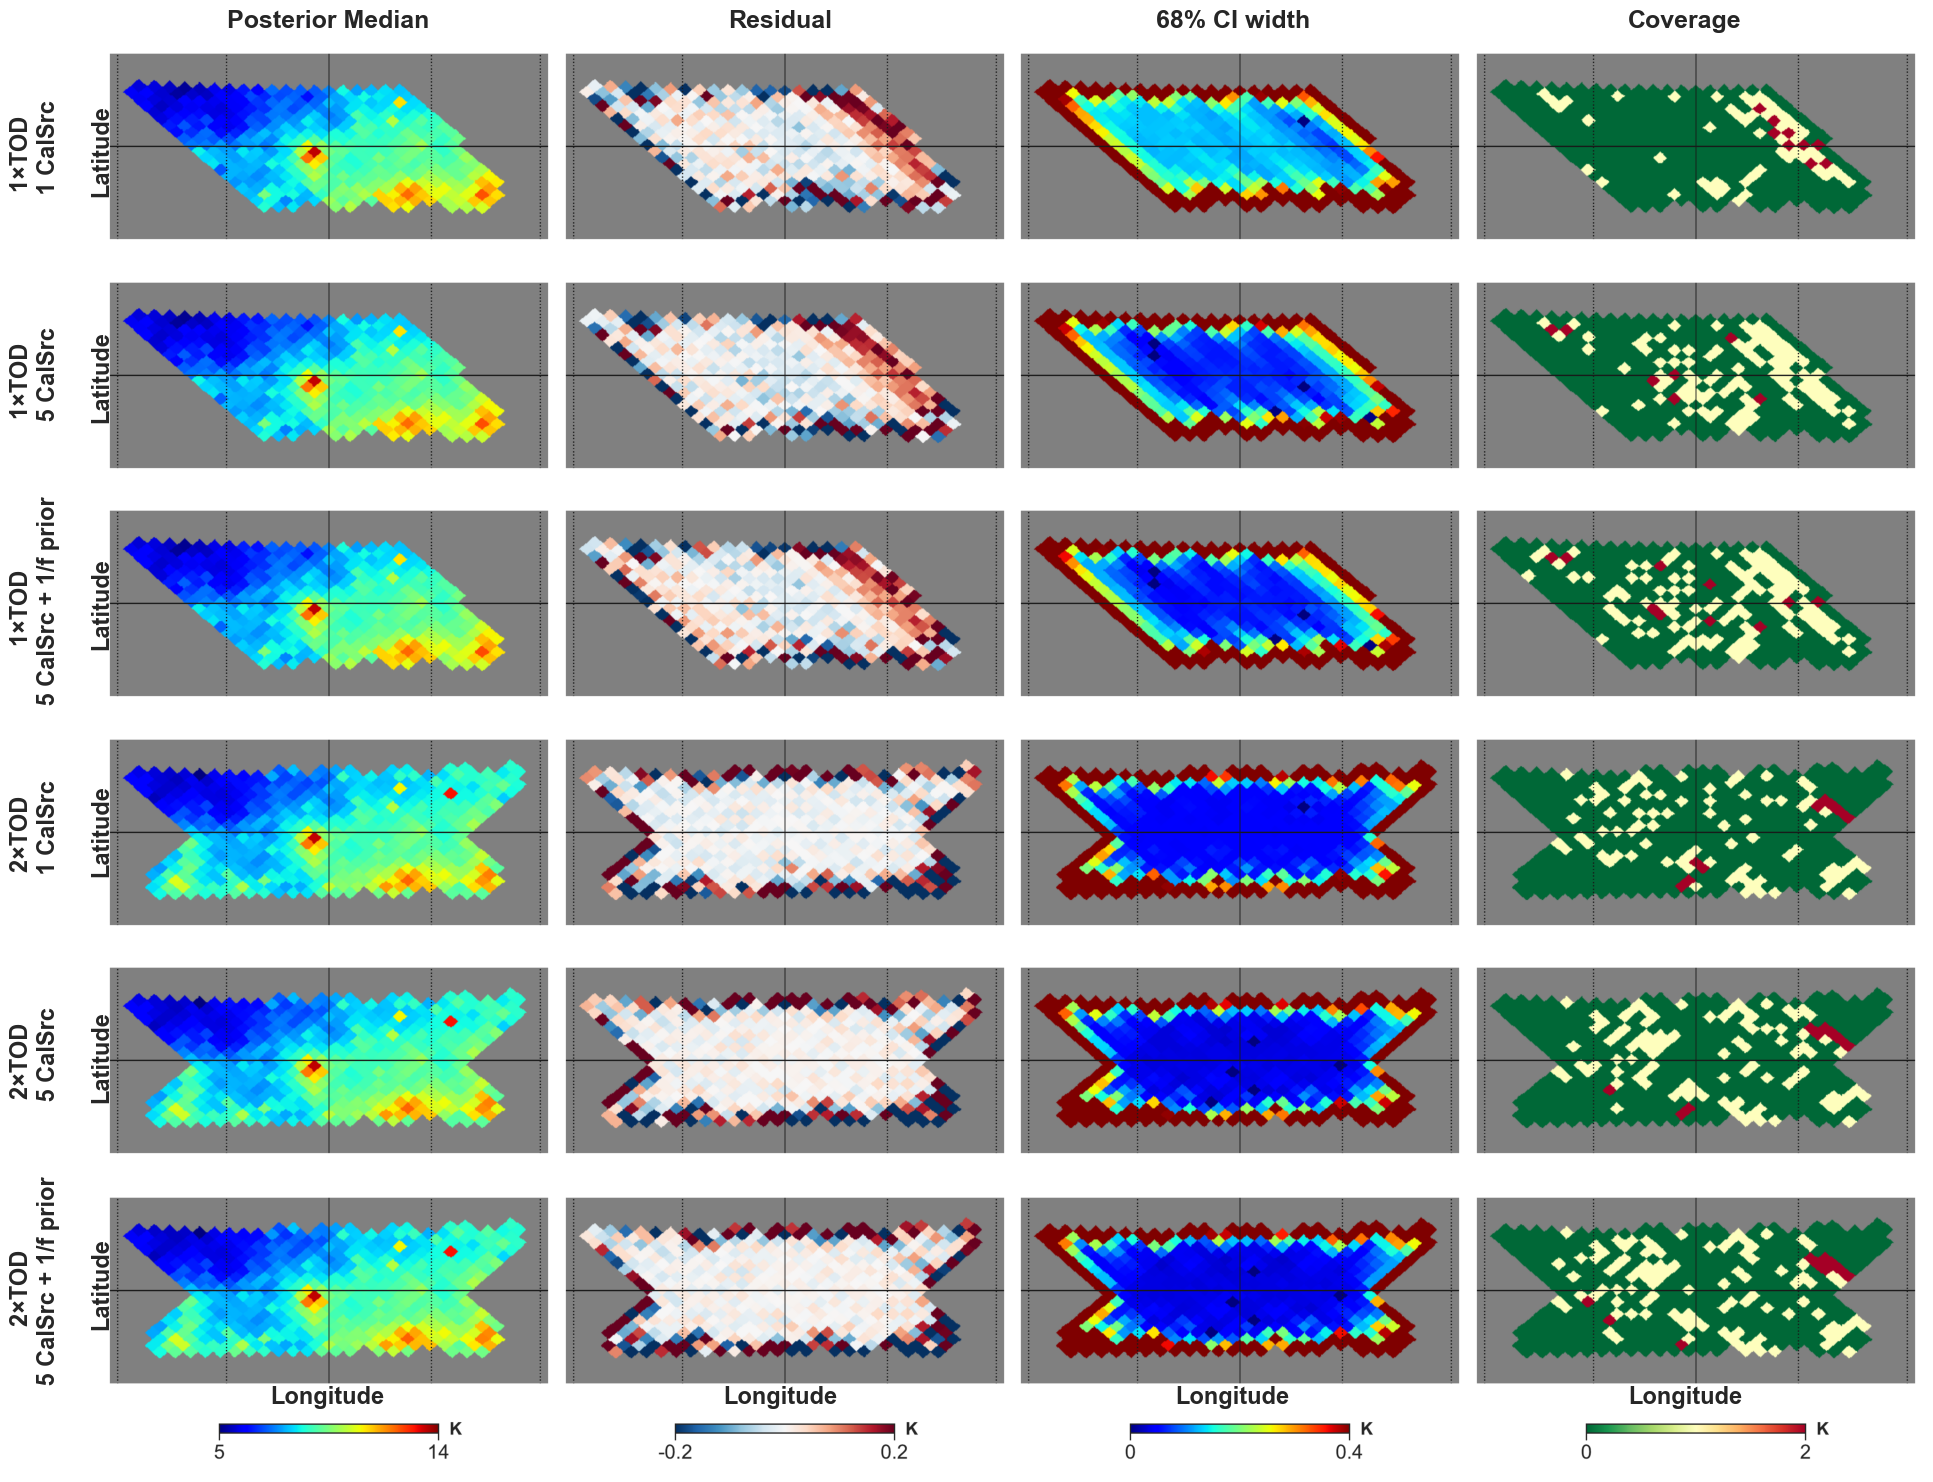

In [54]:

map_pdfs = [
    "figures/GS1_median_map.pdf",
    "figures/GS1_med_err_map.pdf",
    "figures/GS1_ci_map.pdf",
    "figures/GS1_coverage_map.pdf",
    "figures/GS5_median_map.pdf",
    "figures/GS5_med_err_map.pdf",
    "figures/GS5_ci_map.pdf",
    "figures/GS5_coverage_map.pdf",
    "figures/GSF5_median_map.pdf",
    "figures/GSF5_med_err_map.pdf",
    "figures/GSF5_ci_map.pdf",
    "figures/GSF5_coverage_map.pdf",
    "figures/GS1_db_median_map.pdf",
    "figures/GS1_db_med_err_map.pdf",
    "figures/GS1_db_ci_map.pdf",
    "figures/GS1_db_coverage_map.pdf",
    "figures/GS5_db_median_map.pdf",
    "figures/GS5_db_med_err_map.pdf",
    "figures/GS5_db_ci_map.pdf",
    "figures/GS5_db_coverage_map.pdf",
    "figures/GSF5_db_median_map.pdf",
    "figures/GSF5_db_med_err_map.pdf",
    "figures/GSF5_db_ci_map.pdf",
    "figures/GSF5_db_coverage_map.pdf"
]



combine_pdfs_to_panels_v2(
    pdf_files=map_pdfs,
    output_file="figures/combined_median_maps.pdf",
    rows=6, cols=4,
    titles=None,
    col_labels=['Longitude']*4,
    row_labels=panel_titles,
    figsize=(20, 16),
    # add_panel_labels=True,  # Enable panel labels
    panel_label_fontsize=17,
    ya=0.85, yb=0.13, yl=0.02,
    xa=0.905, xb=0.08, xl=-0.05,
    map_names = ['Posterior Median', 'Residual', '68% CI width', 'Coverage']
)

In [68]:
# Get indices where GS1_Tsky_coverage equals 1
indices_of_ones = np.where(GS1_Tsky_coverage == 2)[0]

# Get the 5th occurrence (index 4, since Python is 0-indexed)
fifth_index = indices_of_ones[4]

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


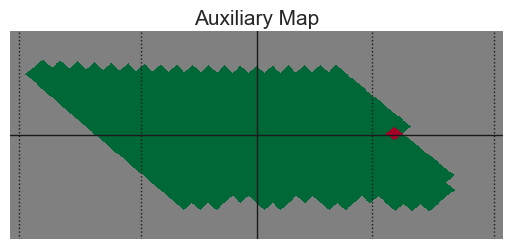

In [70]:
aux_map = np.zeros_like(GS1_Tsky_coverage)

# Set the 5th occurrence to 2
aux_map[fifth_index] = 2

gnomview_patch(aux_map, 
               pixel_indices_setting, 
               lon_center, 
               lat_center,
               res,
               0.0, 
               2.0,
               title="Auxiliary Map",
               cmap='RdYlGn_r',
               cbar=False,
               xtick=False,
               xlabel=None,
               ytick=False,
               ylabel=None,
               save_path=None
               )

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31251/929761290.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Compact plot saved to: figures/pixel_parameter_correlations_compact.pdf


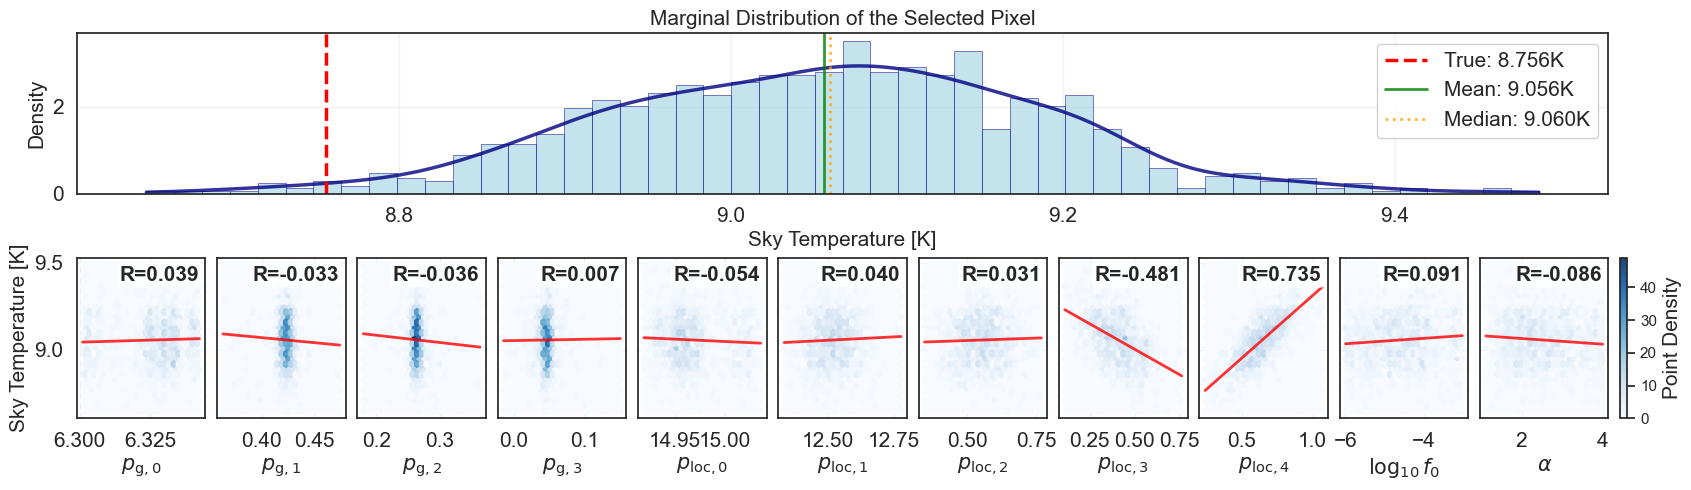

In [89]:
individual_pixel_samples = GS1_Tsys_samples[:, fifth_index]
individual_pixel_truth = sky_params_setting[fifth_index]

def plot_pixel_parameter_correlations_compact(pixel_samples, other_params, pixel_truth, 
                                             param_names=None, figsize=(16, 6), ft_size=14,
                                             save_path=None):
    """
    Compact correlation plot: marginal on top, all correlations in bottom row with shared y-axis
    
    Parameters:
    -----------
    pixel_samples : array-like, shape (N_samples,)
        MCMC samples for the individual pixel
    other_params : array-like, shape (N_samples, N_params)
        MCMC samples for other parameters
    pixel_truth : float
        True value of the pixel
    param_names : list of str, optional
        Names for the other parameters
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import pearsonr, gaussian_kde
    from matplotlib.gridspec import GridSpec
    
    n_params = other_params.shape[1]
    
    # Default parameter names if not provided
    if param_names is None:
        param_names = [f'Param {i+1}' for i in range(n_params)]
    
    # Create figure with GridSpec for better control
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, n_params + 1, figure=fig, 
                  height_ratios=[1, 1], 
                  width_ratios=[1] * n_params + [0.05],  # Extra column for colorbar
                  hspace=0.4, wspace=0.1)
    
    # Top row: Marginal distribution (spans all columns except colorbar)
    ax_marginal = fig.add_subplot(gs[0, :-1])
    
    # Plot histogram with KDE
    n_bins = 50
    counts, bins, patches = ax_marginal.hist(pixel_samples, bins=n_bins, 
                                           density=True, alpha=0.7, 
                                           color='lightblue', edgecolor='navy', 
                                           linewidth=0.5)
    
    # Add KDE overlay
    kde = gaussian_kde(pixel_samples)
    x_kde = np.linspace(pixel_samples.min(), pixel_samples.max(), 200)
    y_kde = kde(x_kde)
    ax_marginal.plot(x_kde, y_kde, 'navy', linewidth=2.5, alpha=0.8)
    
    # Add vertical lines for statistics
    pixel_mean = np.mean(pixel_samples)
    pixel_std = np.std(pixel_samples)
    pixel_median = np.median(pixel_samples)
    
    ax_marginal.axvline(pixel_truth, color='red', linestyle='--', 
                       linewidth=2.5, label=f'True: {pixel_truth:.3f}K')
    ax_marginal.axvline(pixel_mean, color='green', linestyle='-', 
                       linewidth=2, alpha=0.8, label=f'Mean: {pixel_mean:.3f}K')
    ax_marginal.axvline(pixel_median, color='orange', linestyle=':', 
                       linewidth=2, alpha=0.8, label=f'Median: {pixel_median:.3f}K')

    ax_marginal.set_xlabel('Sky Temperature [K]', fontsize=ft_size)
    ax_marginal.set_ylabel('Density', fontsize=ft_size)
    ax_marginal.set_title(f'Marginal Distribution of the Selected Pixel', fontsize=ft_size)
    ax_marginal.legend(loc='upper right', fontsize=ft_size, framealpha=0.9)
    ax_marginal.grid(True, alpha=0.3)
    # tick
    ax_marginal.tick_params(axis='both', which='major', labelsize=ft_size)
    ax_marginal.tick_params(axis='both', which='minor', labelsize=ft_size)

    # Bottom row: Correlation plots with shared y-axis
    correlations = []
    y_min, y_max = pixel_samples.min(), pixel_samples.max()
    y_range = y_max - y_min
    y_min -= 0.05 * y_range  # Add 5% padding
    y_max += 0.05 * y_range
    
    # Find global vmin/vmax for consistent colormapping
    all_hexbin_counts = []
    hexbin_data = []
    
    # First pass: collect all hexbin data to determine color scale
    for i in range(n_params):
        # Create temporary plot to get counts
        fig_temp, ax_temp = plt.subplots()
        hb_temp = ax_temp.hexbin(other_params[:, i], pixel_samples, 
                               gridsize=25, extent=None)
        counts_temp = hb_temp.get_array()
        all_hexbin_counts.extend(counts_temp)
        hexbin_data.append((other_params[:, i], pixel_samples))
        plt.close(fig_temp)
    
    vmin, vmax = np.min(all_hexbin_counts), np.max(all_hexbin_counts)
    
    # Second pass: create actual plots with shared color scale
    axes_bottom = []
    hexbins = []
    
    for i in range(n_params):
        ax = fig.add_subplot(gs[1, i])
        axes_bottom.append(ax)
        
        # Calculate correlation
        corr_coef, p_value = pearsonr(pixel_samples, other_params[:, i])
        correlations.append(corr_coef)
        
        # Create hexbin plot with shared color scale
        hb = ax.hexbin(other_params[:, i], pixel_samples, 
                      gridsize=25, cmap='Blues', alpha=0.9,
                      vmin=vmin, vmax=vmax)
        hexbins.append(hb)
        
        # Add trend line
        z = np.polyfit(other_params[:, i], pixel_samples, 1)
        p_poly = np.poly1d(z)
        x_trend = np.linspace(other_params[:, i].min(), other_params[:, i].max(), 100)
        ax.plot(x_trend, p_poly(x_trend), "red", alpha=0.8, linewidth=2)
        
        # Add correlation text
        ax.text(0.95, 0.95, f'R={corr_coef:.3f}', 
               transform=ax.transAxes, ha='right', va='top',
               bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.8),
               fontsize=ft_size, fontweight='bold')
        
        # Set labels and limits
        ax.set_xlabel(param_names[i], fontsize=ft_size)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=ft_size)
        ax.tick_params(axis='both', which='minor', labelsize=ft_size)

        # Only label y-axis on leftmost plot
        if i == 0:
            ax.set_ylabel('Sky Temperature [K]', fontsize=ft_size)
        else:
            ax.set_yticklabels([])
    
    # Add shared colorbar
    cbar_ax = fig.add_subplot(gs[1, -1])
    cbar = fig.colorbar(hexbins[0], cax=cbar_ax, shrink=0.8)
    cbar.set_label('Point Density', fontsize=ft_size)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Compact plot saved to: {save_path}")
    
    plt.show()
    
    return correlations

param_names_compact = [
    r'$p_{{\rm g},0}$', r'$p_{{\rm g},1}$', r'$p_{{\rm g},2}$', r'$p_{{\rm g},3}$',  # 4 gain parameters
    r'$p_{{\rm loc},0}$', r'$p_{{\rm loc},1}$', r'$p_{{\rm loc},2}$', r'$p_{{\rm loc},3}$', r'$p_{{\rm loc},4}$',  # 5 receiver parameters
    r'$\log_{10} f_0$', r'$\alpha$'  # 2 noise parameters
]

# Create the compact correlation plot
correlations_compact = plot_pixel_parameter_correlations_compact(
    individual_pixel_samples, 
    GS1_others, 
    individual_pixel_truth,
    param_names=param_names_compact,
    ft_size=15,
    figsize=(20, 5),  # Wider to accommodate all parameters in one row
    save_path="figures/pixel_parameter_correlations_compact.pdf"
)


**Figure X. Posterior correlations between individual pixel reconstruction and nuisance parameters.** 

*Top:* Marginal posterior distribution of sky temperature for a representative pixel. The red dashed line shows the true value, with posterior mean (green) and median (orange) overlaid on the histogram and kernel density estimate.

*Bottom:* Correlation analysis between pixel samples and nuisance parameters: gain coefficients ($p_{\rm g,0}$–$p_{\rm g,3}$), receiver temperature coefficients ($p_{\rm loc,0}$–$p_{\rm loc,4}$), and noise parameters ($\log_{10} f_0$, $\alpha$). Hexagonal density plots show sample distributions with linear regression fits (red lines) and Pearson correlation coefficients. Shared y-axis and colorbar enable direct comparison across parameters.

In [114]:
# Make the trace plot (sample vs sample index) of the pixel:
def plot_pixel_trace(pixel_samples, pixel_truth, figsize=(16, 6), ft_size=14, save_path=None):
    """
    Plot the trace of MCMC samples for a single pixel.
    
    Parameters:
    -----------
    pixel_samples : array-like, shape (N_samples,)
        MCMC samples for the individual pixel
    pixel_truth : float
        True value of the pixel
    figsize : tuple
        Figure size (width, height) in inches
    ft_size : int
        Font size for labels and title
    save_path : str, optional
        Path to save the figure
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot trace
    ax.plot(pixel_samples, color='blue', alpha=0.7)
    
    # Add horizontal line for true value
    ax.axhline(pixel_truth, color='red', linestyle='--', label=f'True: {pixel_truth:.3f}K')
    
    # Add labels and title
    ax.set_xlabel('Sample Index', fontsize=ft_size)
    ax.set_ylabel('Sky Temperature [K]', fontsize=ft_size)
    ax.set_title('Trace of Samples for Selected Pixel', fontsize=ft_size)
    
    # Add legend
    ax.legend(fontsize=ft_size)
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=ft_size)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Trace plot saved to: {save_path}")
    
    plt.show()

Trace plot saved to: figures/pixel_trace_plot.pdf


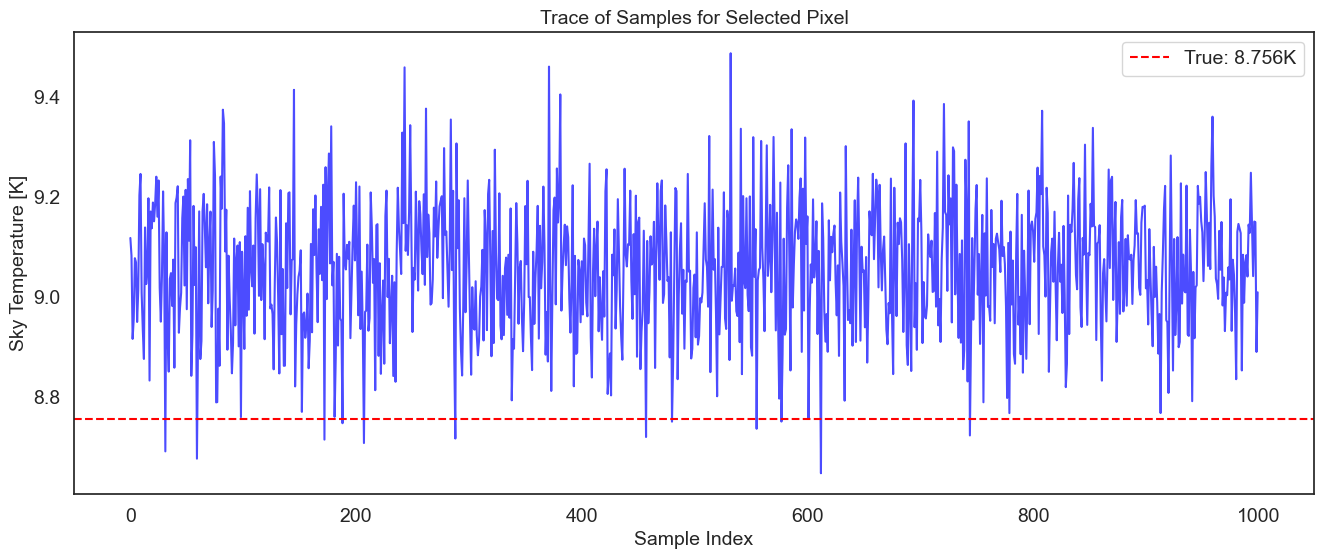

In [115]:
plot_pixel_trace(individual_pixel_samples, individual_pixel_truth, save_path='figures/pixel_trace_plot.pdf')